# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
# import caffeine
from datetime import datetime
import logging, os
from numba import njit, jit
import matplotlib.animation as ani

## Daily Python Zen

In [39]:
import this

## Set logger to log caching activity

In [40]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Version of 21cmFAST

In [41]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.0.dev5


## Number of cores running

In [42]:
print(f'Number of threads running = {os.cpu_count()}')

Number of threads running = 16


## Reset cache location 

In [43]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Gaussian function

In [44]:
@njit
def gaussian(x):  # μ=0, σ=1/sqrt(2), π=1
    """
    Gaussian distribution with amplitude=1,
    mu=0, standard deviation=1/sqrt(2), pi=1.
    @njit by numba compiles the code in machine code 
    instead of python, speeding up the computation.
    
    Parameters
    ----------
    x        : array_like
        Independent variable
        
    Returns
    -------
    gaussian : array_like
        Gaussian distribution array
    """
    gaussian = np.exp(-x**2)
    return gaussian

## Measure the distance of each voxel to the center

In [45]:
@jit
def distance_from_coordinate(box_length):
    """
    Generate a cube of voxels.
    On each voxel, the distanace from the center is 
    calculated and the value is assigned to the voxel.
    jit by numba compiles what it can to machine code,
    the rest as python code.
    
    Parameters
    ----------
    box_length : int
        The length of each side of the cube.
        
    Returns
    -------
    distance : 3D-ndarray
        Cube of voxels with each voxel having its 
        distance from the center assigned to it.
    """
    # range of nummbers with 0 as the center    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    # generating cube and computing distacne for each voxel
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [46]:
def random_cube_regions(box_length, number_of_coordinates, radius):
    """
    Selects a number cubical sub-regions
    within a larger cube at random positions.
    
    Parameters
    ----------
    box_length            : int
        Side length of the larger cube in
        arbitrary units of number of cells.
    number_of_coordinates : int
        Νumber of sub-regions to be selected.
    radius                : int
        Side of the smaller selected cubical 
        sub-region in arbitrary units of number of cells.
        Called radius because a sphere is
        often define within this smaller cube.
        
    Returns
    -------
    inds1 : ndarray dtype:int
        In 1D, the left bound that defines the cubical region.
    inds2 : ndarray dtype:int
        In 1D, the right bound that defines the cubical region.
    """
    
    np.random.seed()  # no entry: set seed to a randome number
#     np.random.seed(4)  # specifying seed for testing purposes

    # selecting 'number_of_coordiantes' random coordinates within larger cube
    coordinates = np.random.randint(0, box_length, size=(number_of_coordinates, 3))
    
    # cube indices 
    inds1 = (coordinates-radius).astype(int)
    inds2 = (coordinates+radius+1).astype(int)  # ending index is not inclusive
    

    return inds1, inds2

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [47]:
def slicing_the_cube(ind1, ind2, box):
    """
    Selects a smaller cubical sub-region within a larger cube called 'box'.
    Incoorporates periodic boundary conditions, i.e. Pac-Man effect.
    This function takes in a set of slicing indices of one particular randomly
    selected cubical sub-region and returns the selected smaller cube.
    
    Parameters
    ----------
    ind1 : 1D ndarray, dtype: int
        The left bounds of the selected region in 1D respectively.
    ind2 : 1D ndarray, dtype: int
        The right bounds of the selected region in 1D respectively.
    box  : 3D ndarray, dtype: float32
        Data cube, when the smaller cubical
        sub-regions are being selected from.
        
    Returns
    -------
    output_box : 3D ndarray, dtype: float32
        The selected cubical smaller sub-region
        within the larger data cube.
    """
        
    if ind1[0] < 0:  # periodic boundary conditions
        # region that went beyond the zeroth voxel face of the
        # cube is replaced by the region at the 'box_length'th
        # voxel face of the cube with the same size.
        x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
    elif ind2[0] > len(box):
        # region that went beyond the 'box_length'th voxel face
        # of the cube is replaced by the region at the zeroth 
        # voxel face of the cube with the same size.
        x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
    else:
        # selected voxel is perfectly in the larger data cube.
        x_inds = np.r_[ind1[0]:ind2[0]]

    if ind1[1] < 0:
        y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
    elif ind2[1] > len(box):
        y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
    else:
        y_inds = np.r_[ind1[1]:ind2[1]]

    if ind1[2] < 0:
        z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
    elif ind2[2] > len(box):
        z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
    else:
        z_inds = np.r_[ind1[2]:ind2[2]]
                    
    try:
        # box[indices]
        output_box = box[np.ix_(x_inds, y_inds, z_inds)]
        
    except IndexError:  # sample region larger than box.
        print(f'ind1 = {ind1}')  # print useful info
        print(f'ind2 = {ind2}')  # for debugging
        print(f'box length = {len(box)}')
        print(f'x_ind1 = {ind1[0]}')
        print(f'x_ind2 = {ind2[0]}')
        print(f'x_inds = {x_inds}')
        print(f'y_ind1 = {ind1[1]}')
        print(f'y_ind2 = {ind2[1]}')
        print(f'y_inds = {y_inds}')
        print(f'z_ind1 = {ind1[2]}')
        print(f'z_ind2 = {ind2[2]}')
        print(f'z_inds = {z_inds}')
        
    return output_box

## Gausssian Sphere Averaging

In [48]:
def gaussian_sphere_average(
    distance_box, 
    radius, 
    input_box, 
    shell_num, 
    sigma_factor
):
    """
    Takes in a cube of voxels and defines 'shell_num'
    of concentric spherical shells and a core.
    A mean is taken over the voxels in each shell and the core.
    Then 'shell_num' equally spaced values are drawn as weights from 0 to 
    'sigma_factor' standard deviations of the Gaussian distribution.
    Each spherical shell and the core is assigned a weight, 
    The inner most core is weighted the most.
    The weights decrease moving outwards through the shells.
    And the outmost shell is weighted the least.
    The function then computes a weighted average over the shells and core.
    
    Parameters
    ----------
    distance_box : 3D ndarray, dtype: float32
        Cube of voxels with each voxel having its 
        distance from the center assigned to it.
        This function uses the distance box to
        set the condition required to slice
        the voxels in the spherical shells.
    radius : int
        Radius of the Guassian sphere, i.e. 
        the sphere complied by the center core 
        and the concentric spherical shells 
        in units of number of voxels.
    input_box : 
    
    
    
    """
    
    
    mean = np.zeros(shell_num)

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    # sigma_factor number of sigmas the weighting goes out to, sigma = radius
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])*sigma_factor 
    weight = gaussian(x=shell_center)
    
    for ii in range(shell_num):
        condition = np.logical_and(
            distance_box <= shell_radius_edges[ii+1]*radius, 
            distance_box > shell_radius_edges[ii]*radius
        )
        mean[ii] = np.mean(input_box[condition])  # inside shell mean
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Top Hat Sphere Averaging

In [49]:
def top_hat_sphere_average(distance_box, radius, input_box):
    
    mean = np.mean(input_box[distance_box <= radius])
    
    return mean

## Top Hat Cube Averaging

In [50]:
@njit
def top_hat_cube_average(input_box):
    
    mean = np.mean(input_box)
    
    return mean

## Make sure averaging region size is not larger than the box itself 

In [51]:
def check_averaging_radius_limit(averaging_radius, box_length):
    # check to see if averaging region is larger than the box itself
    if averaging_radius > (box_length-1)/2:
        raise ValueError(f'Averaging_radius = {averaging_radius} > \
{(box_length-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')

## Sphere Blurring Function

In [52]:
@jit
def average_neutral_fraction_distribution(
    box, 
    radius, 
    iteration, 
    shell_num=6, 
    sigma_factor=1.4370397097748921*3, 
    blur_shape=None
):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    mean_data = np.zeros(iteration)  # empty list for data collection
    
    
    if blur_shape == 'Gaussian_sphere':
        
        
# ====================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  
            # 13/4 --> speculated correction factor
# ====================================================================================================================

        
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))
            
        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
            len(box), 
            iteration, 
            radius
        )  

        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                box
            )
            # mean
            mean_data[i] = gaussian_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box, 
                shell_num, 
                sigma_factor
            )
        
    elif blur_shape == 'top_hat_sphere':
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))
            
        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)
        
        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
            len(box), 
            iteration, 
            radius
        )  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                box
            )
            # mean
            mean_data[i] = top_hat_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box
            )
            
    elif blur_shape == 'top_hat_cube':
                
        # ratio determiend by equating the volumes of cube & sphere
        radius = int(round((radius*((4*np.pi/3)**(1/3))-1)/2))  

        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))

        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
            len(box), 
            iteration, 
            radius
        )  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                box
            )
            # mean
            mean_data[i] = top_hat_cube_average(cube_region_box)
    else:
        
        print('Blurring shape assumed to be a Gaussian sphere with 4 shells \
              weighted by equally spaced values from 0 sigma to 4 sigma.')
                
        
# ====================================================================================================================
        # Radius Ratio 1
        radius = int(round(radius*1.4370397097748921*3))
        
        # Radius Ratio 2
#         radius = int(round(radius*((4/3/np.sqrt(np.pi))**(1/3))*13/4))  
            # 13/4 --> speculated correction factor
# ====================================================================================================================
        
        
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))

        # used as condition to define a sphere within a cube
        dist_frm_coord_box = distance_from_coordinate(radius*2+1)

        # iteration number of random cube region indices in the box
        rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
            len(box), 
            iteration, 
            radius
        )  
        
        for i in range(iteration):
            cube_region_box = slicing_the_cube(
                rand_coord_inds1[i, :], 
                rand_coord_inds2[i, :], 
                box
            )
            mean_data[i] = gaussian_sphere_average(
                dist_frm_coord_box, 
                radius, 
                cube_region_box, 
                shell_num, 
                sigma_factor
            )
            # mean
            
    return mean_data

## Histogram Function

In [53]:
def histogram(
    y1s, 
    figure_shape, 
    y2s=None,
    y3s=None,
    marker_lines=None,
    y1s_labels=None,
    y2s_label=None,
    y3s_label=None,
    title=None, 
    legend_font_size=12,
    fancy_legend_box=True,
    legend_alpha=0.5,
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.92,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    x_start=0, 
    x_stop=1, 
    bin_num=int(1e3), 
    color='white', 
    figure_size=(18,7), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='linear', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):  # a: x start, b: x stop
    
    bin_edges = np.linspace(x_start, x_stop, bin_num) # bin_num of bins from 0-1
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    if np.array(y1s).ndim > 2:  # hopefully more robust condition.
        
        fig, axes = plt.subplots(
            figure_shape[0], 
            figure_shape[1], 
            figsize=figure_size, 
            sharex=share_x_axis, 
            sharey=share_y_axis, 
            gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
            dpi=dpi
        )
        
        if shared_title != None:
            
            fig.suptitle(
                x=shared_title_x_position, 
                y=shared_title_y_position, 
                t=shared_title, ha='center', 
                size=1.5*font_size, 
                color=color
            )
            
        if shared_x_label != None:  # shared x label
            fig.text(
                x=shared_x_label_x_position, 
                y=shared_x_label_y_position, 
                s=shared_x_label, ha='center', 
                size=font_size, 
                color=color
            )

        if shared_y_label != None:  # shared y label
            fig.text(
                x=shared_y_label_x_position, 
                y=shared_y_label_y_postion, 
                s=shared_y_label, 
                va='center', 
                rotation='vertical', 
                size=font_size, 
                color=color
            )
        
        for i, y1 in enumerate(y1s):
            
            for ii, marker_line in enumerate(marker_lines):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y1s[i,ii,:], bins=bin_edges)[0], 
                    marker_line,
                    label=y1s_labels[ii]
                )
            
            if iterable(y2s):
                axes.flatten()[i].plot(
                    bin_centers, 
                    np.histogram(y2s[i], bins=bin_edges)[0], 
                    '--', 
                    label=y2s_label
                )
                
                if iterable(y3s):
                    axes.flatten()[i].plot(
                        bin_centers, 
                        np.histogram(y3s[i], bins=bin_edges)[0], 
                        label=y3s_label
                    )
                    
                    
            if y1s_labels != None:
                axes.flatten()[i].legend(
                    prop={'size': legend_font_size}, 
                    fancybox=fancy_legend_box, 
                    framealpha=legend_alpha
                )
                
            if title != None:
                axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)
                
            axes.flatten()[i].set_yscale(y_scale)
            
            if y_notation == 'sci':
                axes.flatten()[i].ticklabel_format(
                    axis='y', 
                    style=y_notation, 
                    scilimits=(0,0), 
                    useMathText=True
                )
                
            axes.flatten()[i].tick_params(
                color=color, 
                labelcolor=color, 
                labelsize=font_size, 
                size=font_size
            )  # font style

            for spine in axes.flatten()[i].spines.values():  # figure color
                spine.set_edgecolor(color)
                
    else:
        
        fig, ax = plt.subplots(figsize=figure_size)
        
        ax.plot(bin_centers, np.histogram(y1s, bins=bin_edges)[0], label=y1s_labels)
        
        if y2s != None:
            ax.plot(bin_centers, np.histogram(y2s, bins=bin_edges)[0], '--', label=y2s_label)
            
            if y3s == None:
                ax.legend(
                    prop={'size': legend_font_size}, 
                    fancybox=fancy_legend_box, 
                    framealpha=legend_alpha
                )                 
                
            else:
                ax.plot(bin_centers, np.histogram(y3s, bins=bin_edges)[0], '-.', label=y3s_label)
                ax.legend(
                    prop={'size': legend_font_size}, 
                    fancybox=fancy_legend_box, 
                    framealpha=legend_alpha
                )                 
                
        if title != None:
            ax.set_title(title, color=color, fontsize=font_size)
            
        ax.set_yscale(y_scale)
        
        if y_notation == 'sci':
            ax.ticklabel_format(axis='y', style=y_notation, scilimits=(0,0), useMathText=True)
            
        ax.tick_params(color=color, labelcolor=color, labelsize=font_size)  # font style

        for spine in ax.spines.values():  # figure color
            spine.set_edgecolor(color)
            
    plt.show()

## Check if object is iterable

In [54]:
def iterable(obj):
    
    try:
        iter(obj)
        
    except Exception:
        return False
    
    else:
        return True

## MFP alternate neutral region size measurement

In [55]:
from scipy import interpolate
def mfp(
    data, 
    xth=0.5, 
    boxsize=None, 
    iterations = 10000000, 
    verbose=True, 
    upper_lim=False, 
    bins=None, 
    r_min=None, 
    r_max=None
):
    """
    Determines the sizes using the Mean-Free-Path (MFP) approach.

    Parameters
    ----------
    input     : ndarray
        2D/3D array of ionization fraction/brightness temperature.
    xth       : float
        The threshold value (Default: 0.5).
    boxsize   : float
        The boxsize in cMpc can be given (Default: conv.LB).
    iterations: float
        Number of iterations (Default: 1e7).
    verbose   : bool
        It prints the progress of the program (Default: True).
    upper_lim : bool
        It decides if the threshold is the upper limit or the lower limit (Default: False).
    bins      : int
        Give number of bins or an array of sizes to re-bin into (Default: None).
    r_min     : float
        Minimum size after rebinning (Default: None).
    r_max     : float
        Maximum size after rebinning (Default: None).

    Returns
    -------
    r  : ndarray
        sizes of the regions
    dn : ndarray
        probability of finding the corresponding size 
    """
    if boxsize is None:
        boxsize = conv.LB
        print('Boxsize is set to %.2f Mpc.'%boxsize) 
    dim = len(data.shape)
    t1 = datetime.now()
    if (upper_lim): 
        data = -1.*data
        xth  = -1.*xth
    check_box = (data>=xth).sum()
    if check_box==0:
        data = np.ones(data.shape)
        iterations = 3
    if dim == 2:
        print("MFP method applied on 2D data (ver 1.0)")
        #out = mfp2d(data, xth, iterations=iterations, verbose=verbose)
        out = mfp2d(data, xth, iterations=iterations, verbose=verbose)
    elif dim == 3:
        print("MFP method applied on 3D data (ver 1.0)")
        #out = mfp3d(data, xth, iterations=iterations, verbose=verbose)
        out = mfp3d(data, xth, iterations=iterations, verbose=verbose)
    else:
        print("The data doesn't have the correct dimension")
        return 0
    nn = out[0]/iterations
    rr = out[1]
    t2 = datetime.now()
    runtime = (t2-t1).total_seconds()/60

    print("\nProgram runtime: %f minutes." %runtime)
    if check_box==0:
        print("There is no ROI in the data. Therefore, the BSD is zero everywhere.")
        return rr*boxsize/data.shape[0], np.zeros(rr.shape)
    print("The output contains a tuple with three values: r, rdP/dr")
    print("The curve has been normalized.")
  
    r0,p0 = rr*boxsize/data.shape[0], rr*nn #rr[nn.argmax()]*boxsize/data.shape[0]
    if bins is not None: r0,p0 = rebin_bsd(r0, p0, bins=bins, r_min=r_min, r_max=r_max)
    return r0, p0

def rebin_bsd(rr, pp, bins=10, r_min=None, r_max=None):
    fp = interpolate.interp1d(rr, pp, kind='cubic')
    if np.array(bins).size == 1:
        if r_min is None: r_min = rr.min()+1
        if r_max is None: r_max = rr.max()-10
        rs = 10**np.linspace(np.log10(r_min), np.log10(r_max), bins)
    else: rs = np.array(bins)
    return rs, fp(rs)


## MFP3D & 2D

In [56]:
from scipy.interpolate import RegularGridInterpolator
import sys

def mfp3d(arr, xth=0.5, iterations=10000000, verbose=True):
    #3D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info = arr.shape  # dimensions of the data box

#=========================================================================================================
    longest = int(max(arr.shape)*np.sqrt(3))  
    # longest distance between 2 points in the box, i.e. diagonal corners
    # EDIT: switch the definition of longest to sqrt(3)*longest
#=========================================================================================================
    
    num_sz  = np.zeros(longest)  # place holder with length of the longest axis

    ar  = np.zeros(arr.shape)  # place holder with data box shape
    ar[arr >= xth] = 1  # generating a binary box, xth = threshold

    loc = np.argwhere(ar == 1)  # locations of ionized cells
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)  
    # iterations number of random ionized locations
 
    #==================================================================================
    thetas   = np.random.randint(0, 180, size=iterations)  # should it be 0 to 180 deg?
    # EDIT: switched upper limit from 360 to 180.
    #==================================================================================

    phis     = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)*np.cos(phis*np.pi/180)  # dx
    ms       = np.sin(thetas*np.pi/180)*np.sin(phis*np.pi/180)  # dy
    ns       = np.cos(thetas*np.pi/180)  # dz
    xs,ys,zs = loc[rand_loc,0],loc[rand_loc,1],loc[rand_loc,2]  
    # slicing ionized locations with [randome coordinate, (x,y,z)]

    interp_func = RegularGridInterpolator(
        (np.arange(info[0]), np.arange(info[1]), np.arange(info[2])), 
        ar, 
        bounds_error=False, 
        fill_value=0
    )

    #=========================================================================================================
    for rr in range(longest):  # steping 1 step along the ray for all directions.
    # should it be sqrt(longestX^2, longestY^2, longestZ^2)?
    # motivation: no rays will be longer than the longest axis?
    # EDIT: switch the definition of longest to sqrt(3)*longest
    #=========================================================================================================

        xs,ys,zs = xs+ls,ys+ms,zs+ns  # steping by dx, dy, dz
        pts    = np.vstack((xs,ys,zs)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)  # coordinates that are outsise ionized regions.
        num_sz[rr] = check.shape[0]  # record the number of new rays terminated in this loop
        xs,ys,zs = np.delete(xs, check),np.delete(ys, check),np.delete(zs, check)  # for the terminated rays,
        ls,ms,ns = np.delete(ls, check),np.delete(ms, check),np.delete(ns, check)  # delete the forward step 
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
    size_px = np.arange(longest)
    return num_sz, size_px

def mfp2d(arr, xth=0.5, iterations=1000000, verbose=True):
    #2D interpolation is required
    #RegularGridInterpolator in scipy(>0.14) is used to do the interpolation

    info    = arr.shape
    longy	= max([info[0], info[1]])
    longest = int(np.sqrt(2)*longy)
    num_sz  = np.zeros(longest)

    ar  = np.zeros(arr.shape)
    ar[arr >= xth] = 1

    loc = np.argwhere(ar == 1)
    rand_loc = np.random.randint(0, high=loc.shape[0], size=iterations)
    thetas   = np.random.randint(0, 360, size=iterations)
    ls       = np.sin(thetas*np.pi/180)
    ms       = np.cos(thetas*np.pi/180)

    xs,ys    = loc[rand_loc,0],loc[rand_loc,1]

    interp_func = RegularGridInterpolator(
        (np.arange(info[0]), np.arange(info[1])), 
        ar, 
        bounds_error=False, 
        fill_value=0
    )

    for rr in range(longest):
        xs,ys  = xs+ls,ys+ms
        pts    = np.vstack((xs,ys)).T
        vals   = interp_func(pts)
        check  = np.argwhere(vals<=0.5)
        num_sz[rr] = check.shape[0]
        xs,ys  = np.delete(xs, check),np.delete(ys, check)
        ls,ms  = np.delete(ls, check),np.delete(ms, check)
        if verbose:
            perc = (rr+1)*100/longest
            msg  = '%.1f'%perc + '%'
            loading_verbose(msg)
        if not xs.size: break
    msg  = '100.0' + '%'
    loading_verbose(msg)
    size_px = np.arange(longest)
    return num_sz, size_px


def loading_verbose(string):
    msg = ("Completed: " + string )
    sys.stdout.write('\r'+msg)
    sys.stdout.flush()

## Friends of friends method

https://tools21cm.readthedocs.io/examples/tutorials.html#Bubble-size-distribution

In [57]:
import sys
import skimage

def fof(data, xth=0.5, connectivity=1):
    """
    Determines the sizes using the friends-of-friends approach.
    It assumes the length of the grid as the linking length.

    Parameters
    ----------
    data: ndarray 
        The array containing the input data
    xth: float 
        The threshold value (Default: 0.5)

    Returns
    -------
    map: ndarray
        array with each regions of interest label
    sizes: list
        all the sizes
    """
    use_skimage=True
    t1 = datetime.now()
    data = (data>=xth)  # creating binary box
    if 'skimage' in sys.modules and use_skimage:  # use skimage if installed
        from skimage import morphology
        out_map = morphology.label(data, connectivity=connectivity)  # box with neutral regions labelled
        elements, size_list = np.unique(out_map, return_counts=True)
        size_list = size_list[1:]  # first entry corresponds to background
    else: out_map, size_list = FoF_search(data, xth)
    t2 = datetime.now()
    runtime = (t2-t1).total_seconds()/60

    print("Program runtime: %f minutes." %runtime)
    print("The output is a tuple containing output-map and volume-list array respectively.")

    return out_map, size_list

## Binning the data with a log scale

In [58]:
def plot_fof_sizes(sizes, bins=100, boxsize=None, normalize='box'):
    lg = np.log10(np.array(sizes))
    ht = np.histogram(lg, bins=bins)
    xx = 10**ht[1]
    yy = ht[0]*xx[:-1]
    if boxsize is None: boxsize = conv.LB
    if normalize=='ionized': zz = yy/np.sum(yy)
    else: zz = yy/boxsize**3
    dummy = zz[zz!=0].min()/10.
    zz[zz==0] = dummy
    zz = np.hstack((zz,dummy))
    print("The output is Size, Size**2 dP/d(Size), lowest value")
    return xx, zz, dummy

## Alternative if sci kit is not installed, currently seems to not work

In [59]:
"""
Implementing a basic searching algorithm to identify grouped areas of high
values in an array
Can either be imported and used in a seperate script, 
or run via command line with an input file and an
output file as arguments. Output file will be a string 
representation of a list, with no modifications, this can be read
in python using the 'ast' module, with:
sizes_list = ast.literal_eval(sizes_string)
"""

import numpy as np
from itertools import count
#from Queue import Queue
from multiprocessing import Queue


def FoF_search(array, threshold):
    """
    :param array: n-dimensional scalar array to search
    :param threshold: float
    :return: (out_map, size_list) n-dimensional array with points 
    filled with corresponding group number
        (0 if not above threshold), and a 1D list containing group sizes
    """
    # generator which returns indices next to a given index
    def cycle_through_options(coord):    
        for i in range(len(coord)):
            for j in [-1, 1]:
                new_coordinate = [k for k in coord]
                new_coordinate[i] += j
                yield tuple(new_coordinate)

    # creates an array with the same shape as the input search array
    out_map = np.zeros(array.shape, dtype=int)   
    # creates a list of indices of points above the threshold
    possibilities = zip(*np.where(array > threshold))  
    poss_set = set(possibilities)
    
    # function to calculate group membership of a point
    def recursive_search(point, current_group, currentsize):    
        for testPoint in cycle_through_options(point):
            if testPoint in poss_set and not out_map[testPoint]:
                out_map[testPoint] = current_group
                q.put(testPoint)
                currentsize += 1
        return currentsize
    c = count()
    #c.next()
    next(c)
    size_list = []
    q = Queue()             # initialise a queue
    for p in possibilities:     # start cycling through possible points
        if not out_map[p]:           # if the point has not already been searched,
            group = next(c)        # start a new group number
            # assign the corresponding point in the group map to this group
            out_map[p] = group       
            q.put(p)                # put the point in the queue
            s = 1                   # s contains the new group size
            while not q.empty():    # cycle till queue is empty
                s = recursive_search(q.get(), group, s)  # search each neighbour recursively
            size_list.append(s)     # add size of group to a list
    return out_map, np.array(size_list)


# Probably old outdated code that authors left around

# def gaussian(dx, sig):
#     """returns a one dimensional gaussian"""
#     return np.exp(-dx**2.0/(2.0*sig**2.0))


# def halo3d(x, a, sigma, array_size):
#     """
#     Returns an array with size arSize^3 and one gaussian
#     distribution with amplitude a and s.d. sigma
#     somewhere within that array
#     :param x: 3d vector to be the mean of gaussian
#     :param a: float amplitude
#     :param sigma: float s.d.
#     :param array_size: size of array to output
#     :return: 3d array as detailed above
#     """
#     ar = np.zeros(array_size, dtype=float)
#     for i in range(array_size[0]):
#         for j in range(array_size[1]):
#             for k in range(array_size[2]):
#                 dx = float(reduce(lambda foo, y: foo+y**2, [0, i-x[0], j-x[1], k-x[2]]))
#                 ar[i, j, k] = a*gaussian(dx, sigma)
#     return ar

# if __name__ == "__main__":
#     import sys
#     import c2raytools as c2t
#     try:
#         infile = sys.arg[1]
#         outfile = sys.argv[2]
#         x_file = c2t.XfracFile(infile)
#         ret, sizes = friend_of_friend_search(x_file.xi, 0.5)
#         with open(outfile, 'w') as out_file:
#             out_file.write(str(sizes))
#     except IndexError as e:
#         print("Error: expected an input ionised fraction file and an output file")

## Colorbar function

In [60]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel('Neutral Fraction', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

## Slices plots function

In [61]:
def slices_plots(
    boxes,
    titles,
    color='w',
    figure_shape=[3, 3],
    figure_size=(18, 15),
    font_size=12,
    vertical_gap=0.1,
    horizontal_gap=0.1,
    shared_x_label='Mpc',
    shared_x_label_x_position=0.435,
    shared_x_label_y_position=0.08,
    shared_y_label='Mpc',
    shared_y_label_x_position=0.09,
    shared_y_label_y_postion=0.5,
    shared_title="Fred's Boxes",
    shared_title_x_position=0.5,
    shared_title_y_position=0.92,
    share_x_axis=True,
    share_y_axis=True,
    dpi=100
):

    fig, ax = plt.subplots(
        figure_shape[0], # row
        figure_shape[1], # column
        figsize=figure_size, 
        dpi=dpi,
        sharex=share_x_axis, 
        sharey=share_y_axis, 
        gridspec_kw={"hspace":vertical_gap, 'wspace': horizontal_gap}
    )
    for i, box in enumerate(boxes):
        im = ax.flatten()[i].imshow(
            box[150, :, :], 
            extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
            vmin=0, 
            vmax=1, 
            origin='lower'
        )
        ax.flatten()[i].set_title(
            titles[i], 
            color=color, 
            fontsize=font_size
        )
        ax.flatten()[i].tick_params(color=color, labelcolor=color, labelsize=font_size)

    fig.suptitle(
        x=shared_title_x_position, 
        y=shared_title_y_position, 
        t=shared_title, 
        ha='center', 
        size=1.5*font_size, 
        color=color
    )    

    if shared_x_label != None:  # shared x label
        fig.text(
            x=shared_x_label_x_position, 
            y=shared_x_label_y_position, 
            s=shared_x_label, 
            ha='center', 
            size=font_size, 
            color=color
        )

    if shared_y_label != None:  # shared y label
        fig.text(
            x=shared_y_label_x_position, 
            y=shared_y_label_y_postion, 
            s=shared_y_label, 
            va='center', 
            rotation='vertical', 
            size=font_size, 
            color=color
        )

    cbar = plt.colorbar(im, ax=ax.ravel().tolist())
    cbar.set_label("Neutral Fraction", color=color, size=font_size)
    cbytick_labels = plt.getp(cbar.ax.axes, 'yticklabels')                #tricky
    plt.setp(cbytick_labels, color=color, size=font_size)
    cbar.ax.yaxis.set_tick_params(color=color)

    plt.show()

## Cosmological Parameters (Default is used when no input is specified)

In [62]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [63]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [64]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-12-16 16:26:08.626974


KeyboardInterrupt: 

## Vary: z, EFF, constant: x_HI, Rmax. x_HI error: 1e-3%

redshifts = np.linspace(6.72, 5.8, 9)
HII_EFF_FACTORS = np.array(
    [32.95, 
     31.025, 
     29.2275, 
     27.5475, 
     25.974, 
     24.4995, 
     23.1165, 
     21.8215, 
     20.60875]
)
R_BUBBLE_MAXES = np.array([30]*len(redshifts))

## Vary: Rmax, EFF, constant: x_HI, z. x_HI error: 1e-2%

In [ ]:
R_BUBBLE_MAXES = np.linspace(30, 0.225, 9)
HII_EFF_FACTORS = np.array(
    [19.04625, 
     19.511249999999997, 
     20.23875, 
     21.085, 
     22.655000000000012, 
     25.779375, 
     32.056640625, 
     56.6734375, 
     5291.5]
)
redshifts = np.array([6]*len(R_BUBBLE_MAXES))

## CHAMP Bootcamp

In [ ]:
redshifts = np.array([13, 12, 10, 9, 8, 7, 6, 5])
R_BUBBLE_MAXES = np.array([15]*len(redshifts))
HII_EFF_FACTORS = np.array([30]*len(redshifts))

## Compare with Fred's boxes
## Vary: Rmax=10, 20, 30, x_HI=0.1, 0.2, 0.3, EFF=varies, constant: z=7. x_HI error: 0.5%

R_BUBBLE_MAXES = np.array(
    [10, 20, 30]*3
)
HII_EFF_FACTORS = np.array(
    [62.625, 42.042500000000004, 36.183125000000004,
     47.1875, 34.390625, 31.25, 
     37.96875, 29.53125, 27.6875]  
)
redshifts = np.array([7]*len(R_BUBBLE_MAXES))

# Fred's boxes, x_HI match to 0.5%

Freds_HII_EFF_FACTORS = np.array(
    [103.011, 61.105, 48.548,
    73.347, 47.157, 39.005,
    56.294, 38.338, 32.611]
)

filename = ['/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.100687_eff103.011_mfpfilt_Mmin5.1e+08_MFP10_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.100065_eff61.105_mfpfilt_Mmin5.1e+08_MFP20_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.100593_eff48.548_mfpfilt_Mmin5.1e+08_MFP30_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.200023_eff73.347_mfpfilt_Mmin5.1e+08_MFP10_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.200123_eff47.157_mfpfilt_Mmin5.1e+08_MFP20_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.200030_eff39.005_mfpfilt_Mmin5.1e+08_MFP30_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.300143_eff56.294_mfpfilt_Mmin5.1e+08_MFP10_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.300672_eff38.338_mfpfilt_Mmin5.1e+08_MFP20_301_301Mpc',
      '/lustre/aoc/projects/hera/wchin/z7_boxes_fixed/xH_ffrtp_z007.00_nf0.300183_eff32.611_mfpfilt_Mmin5.1e+08_MFP30_301_301Mpc']

dim = 301

Freds_boxes = np.zeros((len(filename), dim, dim, dim))
Freds_total_neutral_fractions = np.zeros(len(filename))


for i, fn in enumerate(filename):
    Freds_boxes[i] = np.fromfile(fn, dtype=np.float32, count=-1).reshape((dim,dim,dim))
    Freds_total_neutral_fractions[i] = np.mean(Freds_boxes[i])

## Generate ionized boxes and total neutral fractions as a function of redshift

In [ ]:
# R_BUBBLE_MAXES = np.array(
#     [10, 20, 30]*3
# )
# HII_EFF_FACTORS = np.array(
#     [62.625, 42.042500000000004, 36.183125000000004,
#      47.1875, 34.390625, 31.25, 
#      37.96875, 29.53125, 27.6875]  
# )
# redshifts = np.array([7]*len(R_BUBBLE_MAXES))

progress_status = True



# sample_range = 10
# target_variable = 0.3  # x_HI neutral fraction
# target_error = 0.5  # percent
# error = 1  # intializing
# while abs(error) > target_variable*target_error/100:



ionized_boxes = np.zeros((len(redshifts), HII_DIM, HII_DIM, HII_DIM))
total_neutral_fractions = np.zeros(len(redshifts))

# print progress and local time
if progress_status:
    start_time = datetime.now()
    current_time = start_time
    print(f'Progress = 0%, localtime = {start_time}')

for i, z in enumerate(redshifts):
    ionized_boxes[i] = p21c.ionize_box(
        redshift=z, 
        init_boxes=init_cond,
        astro_params={
            'HII_EFF_FACTOR': HII_EFF_FACTORS[i],
            'R_BUBBLE_MAX': R_BUBBLE_MAXES[i]
        }
    ).xH_box
    total_neutral_fractions[i] = np.mean(ionized_boxes[i])

    # print progress and local time
    if progress_status:
        previous_time = current_time
        current_time = datetime.now()
        loop_time = current_time - previous_time
        elapsed_time = current_time - start_time
        print(f'progress = {int(round((i+1)*100/len(redshifts)))}%, \
localtime = {current_time}, loopexecuted in {loop_time}, elapsedtime = {elapsed_time}')
        
total_neutral_fractions



#     previous_error=error
#     error = target_variable - total_neutral_fractions[0]
    
#     print(f'HII_EFF_FACTOR={HII_EFF_FACTORS[0]}')
#     print(f'x_HI={total_neutral_fractions[0]}')
#     print(f'sample_range={sample_range}')
#     print(f'previous_error={previous_error}')
#     print(f'error={error}')
    
#     if error > 0:
#         HII_EFF_FACTORS[0] -= sample_range
#     else:
#         HII_EFF_FACTORS[0] += sample_range
        
#     if error*previous_error < 0:
#         sample_range -= 0.5*sample_range

## Plots of slices of our boxes

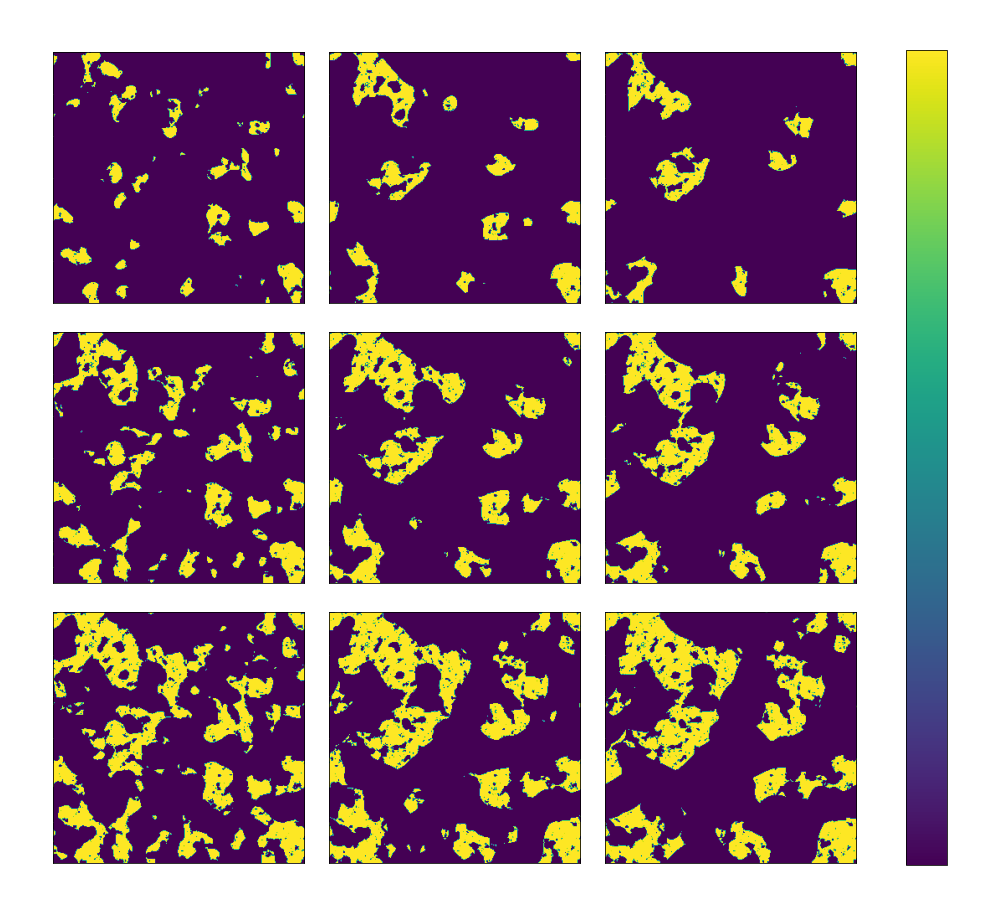

In [95]:
slices_plots(
    boxes=ionized_boxes,
    titles=[f'Rmax={Rmax:d}, \
EFF={HII_EFF_FACTORS[i]:.2f}, \
x_HI={total_neutral_fractions[i]*100:.1f}%\
' for i, Rmax in enumerate(R_BUBBLE_MAXES)],
    shared_title='Our Boxes'
)

## Plot of slices of Fred's boxes

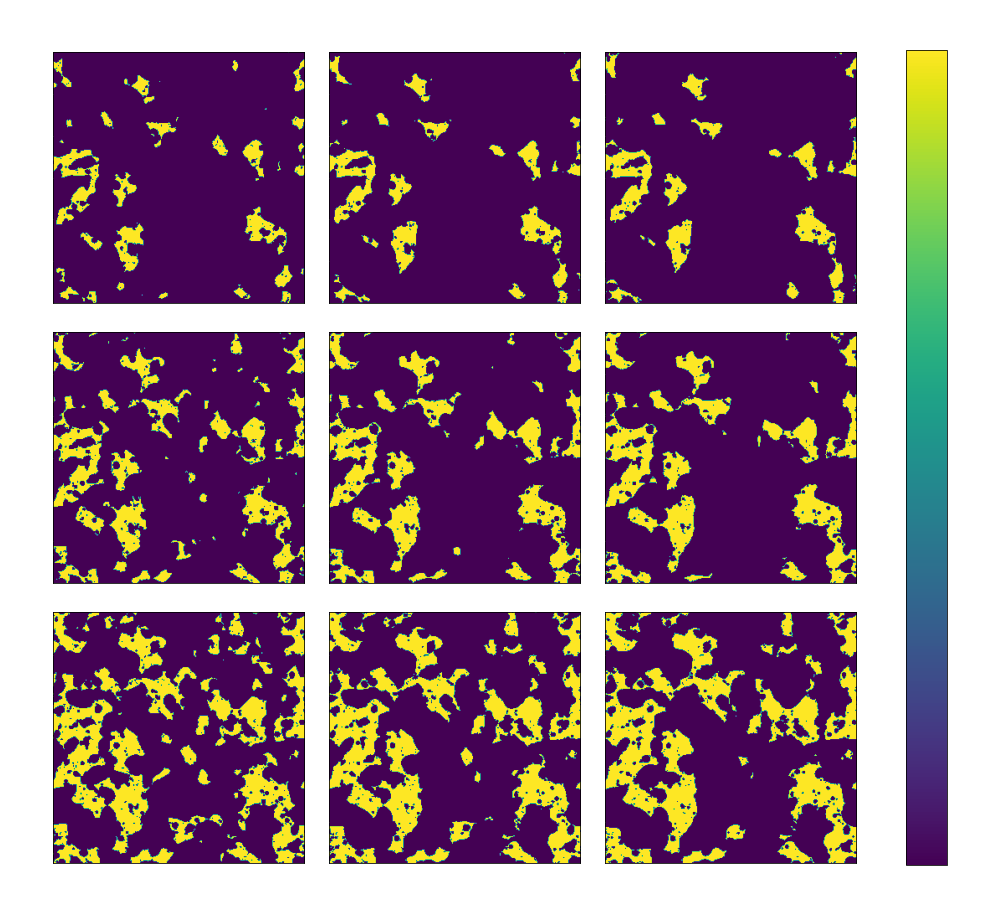

In [97]:
slices_plots()

Text(0, 0.5, 'Light-year')

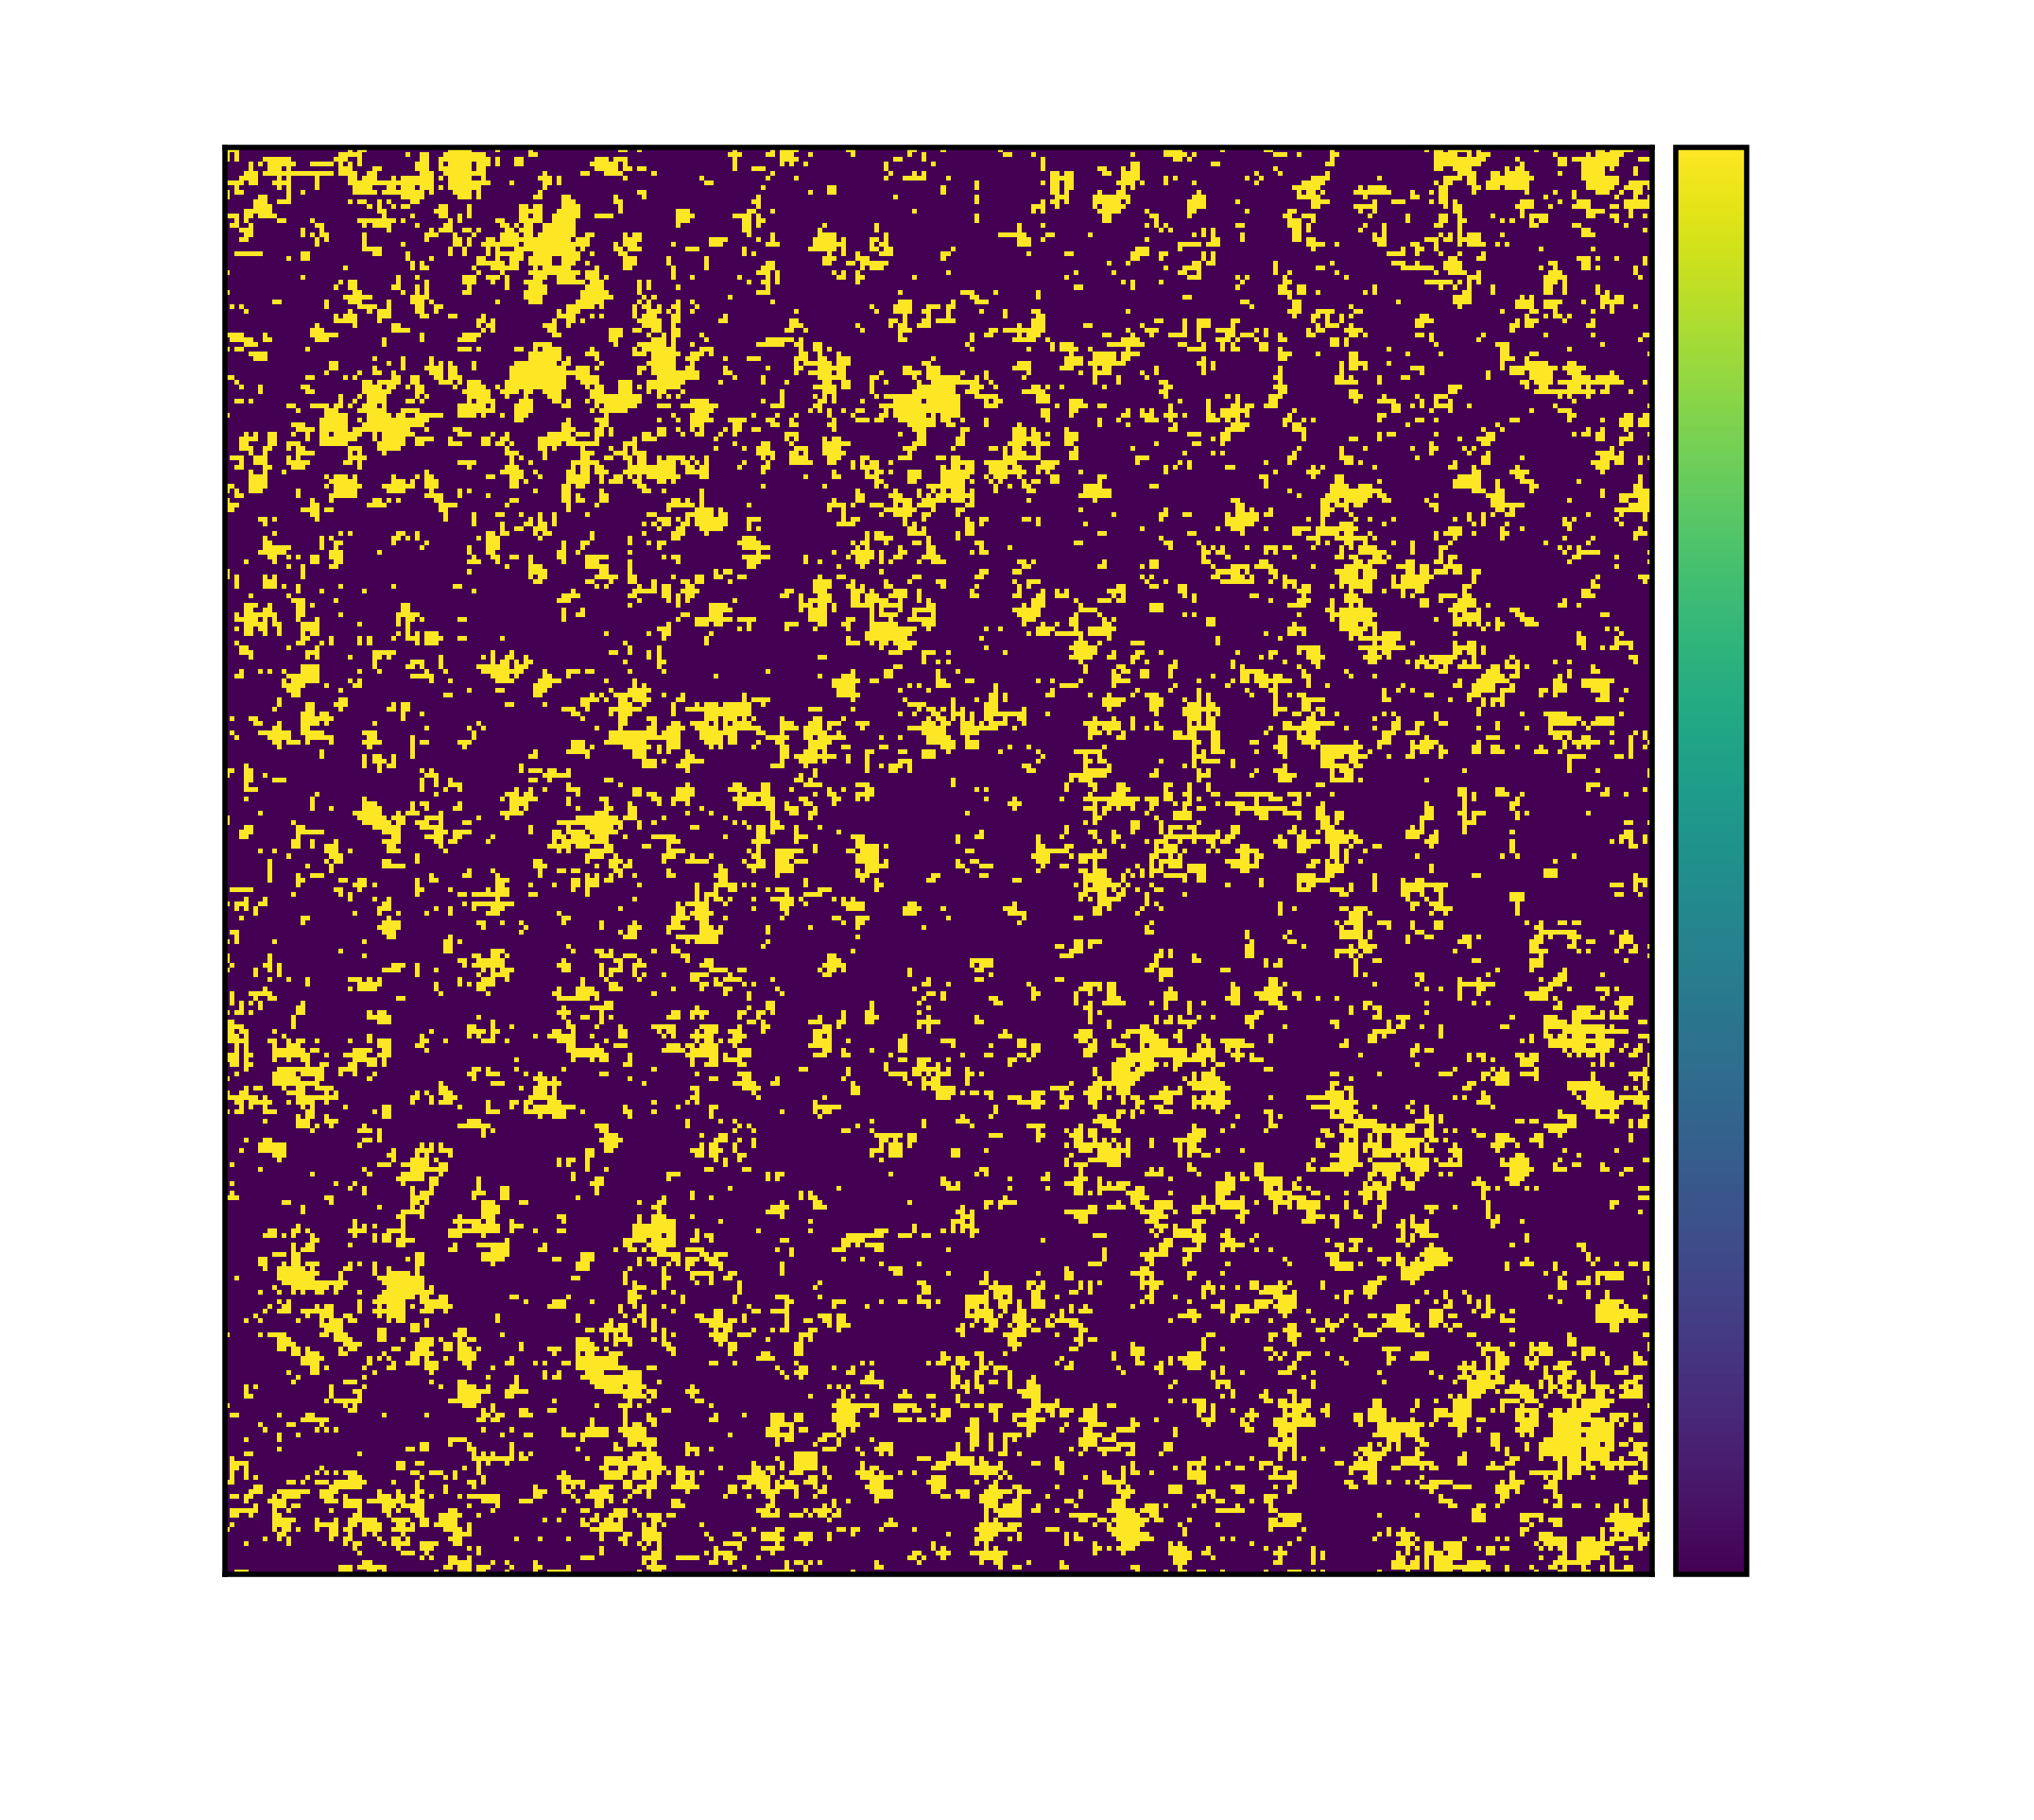

In [33]:
i=8

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    ionized_boxes[i][150, :, :], 
    extent=(0,np.shape(ionized_boxes[i])[1]*3.262e+6,0,np.shape(ionized_boxes[i])[2]*3.262e+6), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'Rmax={R_BUBBLE_MAXES[i]:.2f}, EFF={HII_EFF_FACTORS[i]:.2f}', color=color)
plt.xlabel('Light-year', color=color)
plt.ylabel('Light-year', color=color)

## Cal-Bridge Symposium Figures

In [66]:
def illustration_sphere(
    box,
    radius,
    coordinates
):
    box=box.copy()
    
    # modified to return output_box_indices
    def modified_slicing_the_cube(ind1, ind2, box):
        """
        Selects a smaller cubical sub-region within a larger cube called 'box'.
        Incoorporates periodic boundary conditions, i.e. Pac-Man effect.
        This function takes in a set of slicing indices of one particular randomly
        selected cubical sub-region and returns the selected smaller cube.

        Parameters
        ----------
        ind1 : 1D ndarray, dtype: int
            The left bounds of the selected region in 1D respectively.
        ind2 : 1D ndarray, dtype: int
            The right bounds of the selected region in 1D respectively.
        box  : 3D ndarray, dtype: float32
            Data cube, when the smaller cubical
            sub-regions are being selected from.

        Returns
        -------
        output_box : 3D ndarray, dtype: float32
            The selected cubical smaller sub-region
            within the larger data cube.
        """

        if ind1[0] < 0:  # periodic boundary conditions
            # region that went beyond the zeroth voxel face of the
            # cube is replaced by the region at the 'box_length'th
            # voxel face of the cube with the same size.
            x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
        elif ind2[0] > len(box):
            # region that went beyond the 'box_length'th voxel face
            # of the cube is replaced by the region at the zeroth 
            # voxel face of the cube with the same size.
            x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
        else:
            # selected voxel is perfectly in the larger data cube.
            x_inds = np.r_[ind1[0]:ind2[0]]

        if ind1[1] < 0:
            y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
        elif ind2[1] > len(box):
            y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
        else:
            y_inds = np.r_[ind1[1]:ind2[1]]

        if ind1[2] < 0:
            z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
        elif ind2[2] > len(box):
            z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
        else:
            z_inds = np.r_[ind1[2]:ind2[2]]

        try:
            # box[indices]
            output_box_indices = np.ix_(x_inds, y_inds, z_inds)
            output_box = box[output_box_indices]

        except IndexError:  # sample region larger than box.
            print(f'ind1 = {ind1}')  # print useful info
            print(f'ind2 = {ind2}')  # for debugging
            print(f'box length = {len(box)}')
            print(f'x_ind1 = {ind1[0]}')
            print(f'x_ind2 = {ind2[0]}')
            print(f'x_inds = {x_inds}')
            print(f'y_ind1 = {ind1[1]}')
            print(f'y_ind2 = {ind2[1]}')
            print(f'y_inds = {y_inds}')
            print(f'z_ind1 = {ind1[2]}')
            print(f'z_ind2 = {ind2[2]}')
            print(f'z_inds = {z_inds}')

        return output_box, output_box_indices

    # modified to set the sphere to the average value
    def modified_top_hat_sphere_average(distance_box, radius, input_box):

        mean = np.mean(input_box[distance_box <= radius])
        # really, this is the out_put box, using same
        # variable location to recycle the space in memory
        input_box = np.where(distance_box <= radius, mean, input_box)

        return input_box

    
    # check to see if averaging region is largert than the box itself
    check_averaging_radius_limit(radius, len(box))

    # used as condition to define a sphere within a cube
    dist_frm_coord_box = distance_from_coordinate(radius*2+1)

    # iteration number of random cube region indices in the box
    # cube indices 
    rand_coord_inds1 = (coordinates-radius).astype(int)
    rand_coord_inds2 = (coordinates+radius+1).astype(int)  # ending index is not inclusive

    cube_region_box, cube_region_box_indices = modified_slicing_the_cube(
        rand_coord_inds1, 
        rand_coord_inds2, 
        box
    )
    
    # mean
    output_box = modified_top_hat_sphere_average(
        dist_frm_coord_box, 
        radius, 
        cube_region_box
    )
    
    box[cube_region_box_indices] = output_box
    
    return box

## Binary neutral spheres box

In [31]:
def binary_neutral_spheres_box(
    binary_box_length=300,
    neutral_sphere_radius=50,
    iterations=int(1e2)
):
    box=np.zeros((binary_box_length, binary_box_length, binary_box_length))
    
    # modified to return output_box_indices
    def modified_slicing_the_cube(ind1, ind2, box):
        """
        Selects a smaller cubical sub-region within a larger cube called 'box'.
        Incoorporates periodic boundary conditions, i.e. Pac-Man effect.
        This function takes in a set of slicing indices of one particular randomly
        selected cubical sub-region and returns the selected smaller cube.

        Parameters
        ----------
        ind1 : 1D ndarray, dtype: int
            The left bounds of the selected region in 1D respectively.
        ind2 : 1D ndarray, dtype: int
            The right bounds of the selected region in 1D respectively.
        box  : 3D ndarray, dtype: float32
            Data cube, when the smaller cubical
            sub-regions are being selected from.

        Returns
        -------
        output_box : 3D ndarray, dtype: float32
            The selected cubical smaller sub-region
            within the larger data cube.
        """

        if ind1[0] < 0:  # periodic boundary conditions
            # region that went beyond the zeroth voxel face of the
            # cube is replaced by the region at the 'len(box)gth'th
            # voxel face of the cube with the same size.
            x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
        elif ind2[0] > len(box):
            # region that went beyond the 'len(box)gth'th voxel face
            # of the cube is replaced by the region at the zeroth 
            # voxel face of the cube with the same size.
            x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
        else:
            # selected voxel is perfectly in the larger data cube.
            x_inds = np.r_[ind1[0]:ind2[0]]

        if ind1[1] < 0:
            y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
        elif ind2[1] > len(box):
            y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
        else:
            y_inds = np.r_[ind1[1]:ind2[1]]

        if ind1[2] < 0:
            z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
        elif ind2[2] > len(box):
            z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
        else:
            z_inds = np.r_[ind1[2]:ind2[2]]

        try:
            # box[indices]
            output_box_indices = np.ix_(x_inds, y_inds, z_inds)
            output_box = box[output_box_indices]

        except IndexError:  # sample region larger than box.
            print(f'ind1 = {ind1}')  # print useful info
            print(f'ind2 = {ind2}')  # for debugging
            print(f'box length = {len(box)}')
            print(f'x_ind1 = {ind1[0]}')
            print(f'x_ind2 = {ind2[0]}')
            print(f'x_inds = {x_inds}')
            print(f'y_ind1 = {ind1[1]}')
            print(f'y_ind2 = {ind2[1]}')
            print(f'y_inds = {y_inds}')
            print(f'z_ind1 = {ind1[2]}')
            print(f'z_ind2 = {ind2[2]}')
            print(f'z_inds = {z_inds}')

        return output_box_indices, output_box

    # modified to set the sphere to the average value
    def modified_top_hat_sphere_average(distance_box, neutral_sphere_radius, input_box):

        # really, this is the out_put box, using same
        # variable location to recycle the space in memory
        input_box = np.where(distance_box <= neutral_sphere_radius, 1, input_box)

        return input_box

    
    # check to see if averaging region is largert than the box itself
    check_averaging_radius_limit(neutral_sphere_radius, binary_box_length)

    # used as condition to define a sphere within a cube
    dist_frm_coord_box = distance_from_coordinate(neutral_sphere_radius*2+1)

    # iteration number of random cube region indices in the box
    rand_coord_inds1, rand_coord_inds2 = random_cube_regions(
        binary_box_length, 
        iterations, 
        neutral_sphere_radius
    )  


    
    for i in range(iterations):
        # selecting a cube centered about random coordinate, with sides 2*radius+1
        cube_region_box_indices, cube_region_box = modified_slicing_the_cube(
            rand_coord_inds1[i], 
            rand_coord_inds2[i], 
            box
        )
        
        # neutral sphere centered in a cube
        output_box = modified_top_hat_sphere_average(
            dist_frm_coord_box, 
            neutral_sphere_radius,
            cube_region_box
        )
        # assigning the cube to its place in the larger cube
        box[cube_region_box_indices] = output_box
    
    return box

## Neutral Sphere with Ionized Background Binary Boxes

In [27]:
iteration = [1445, 180, 54, 22]
sphere_radius = [10, 20, 30, 40]

In [28]:
iteration=int(1445)
sphere_radius=10

sample_range = int(5)
target_variable = 0.2  # x_HI neutral fraction
target_error = 0.005  # percent

error = 1  # intializing
while abs(error) > target_error:


    neutral_spheres_box = binary_neutral_spheres_box(
        neutral_sphere_radius=sphere_radius,
        iterations=iteration
    )

    overall_neutral_fraction = np.mean(neutral_spheres_box)

    previous_error=error
    error = (target_variable - overall_neutral_fraction)/target_variable*100
    
    print(f'iteration={iteration}')
    print(f'x_HI={overall_neutral_fraction:.4f}')
    print(f'sample_range={sample_range}')
    print(f'previous_error={previous_error:.4f}%')
    print(f'error={error:.4f}%')
    print(f'error diff={abs(error) - abs(previous_error):.4f}%\n')
    
    if sample_range == 0:
        sys.exit()
    
    if error > 0:
        iteration += sample_range
    else:
        iteration -= sample_range
        
    if error*previous_error < 0:
        sample_range -= 0.5*sample_range
        
    iteration = int(iteration)
    sample_range = int(sample_range)

<ipython-input-8-4c4afb62d49a>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "distance_from_coordinate" failed type inference due to: Use of unsupported NumPy function 'numpy.meshgrid' or unsupported use of the function.

File "<ipython-input-8-4c4afb62d49a>", line 24:
def distance_from_coordinate(box_length):
    <source elided>
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    ^

During: typing of get attribute at <ipython-input-8-4c4afb62d49a> (24)

File "<ipython-input-8-4c4afb62d49a>", line 24:
def distance_from_coordinate(box_length):
    <source elided>
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    ^

  @jit
/lustre/aoc/projects/hera/wchin/anaconda3/envs/21cmfast/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "distance_from_coordinate" was compiled in object mode without forceobj=True.

Fi

iteration=1445
x_HI=0.2001
sample_range=5
previous_error=1.0000%
error=-0.0712%
error diff=-0.9288%

iteration=1440
x_HI=0.2003
sample_range=2
previous_error=-0.0712%
error=-0.1466%
error diff=0.0754%

iteration=1438
x_HI=0.1997
sample_range=2
previous_error=-0.1466%
error=0.1659%
error diff=0.0193%

iteration=1440
x_HI=0.1994
sample_range=1
previous_error=0.1659%
error=0.3107%
error diff=0.1448%

iteration=1441
x_HI=0.2002
sample_range=1
previous_error=0.3107%
error=-0.1007%
error diff=-0.2100%

iteration=1440
x_HI=0.1996
sample_range=0
previous_error=-0.1007%
error=0.1989%
error diff=0.0982%



SystemExit: 

/lustre/aoc/projects/hera/wchin/anaconda3/envs/21cmfast/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [28]:
iterations = np.array([1445, 180, 54, 22])
sphere_radii = np.array([10, 20, 30, 40])
binary_box_length=300


neutral_spheres_boxes = np.zeros((len(sphere_radii), binary_box_length, binary_box_length, binary_box_length))
overall_neutral_fractions = np.zeros(len(sphere_radii))

for i, radius in enumerate(sphere_radii):
    neutral_spheres_boxes[i] = binary_neutral_spheres_box(
        binary_box_length=binary_box_length,
        neutral_sphere_radius=radius,
        iterations=iterations[i]
    )
    
    overall_neutral_fractions[i] = np.mean(neutral_spheres_boxes[i])

In [36]:
radii=[10, 20, 30]
distribution_iterations=int(2.44e4)
neutral_spheres_statistics = generate_distributions(
    boxes=neutral_spheres_boxes[:-1],
    radii=radii,
    iterations=distribution_iterations
)

Progress = 0%, localtime = 2020-08-14 10:15:45.544896


<ipython-input-15-521f3fee503c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "average_neutral_fraction_distribution" failed type inference due to: Untyped global name 'check_averaging_radius_limit': cannot determine Numba type of <class 'function'>

File "<ipython-input-15-521f3fee503c>", line 31:
def average_neutral_fraction_distribution(
    <source elided>
        # check to see if averaging region is largert than the box itself
        check_averaging_radius_limit(radius, len(box))
        ^

  @jit
<ipython-input-15-521f3fee503c>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "average_neutral_fraction_distribution" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-15-521f3fee503c>", line 21:
def average_neutral_fraction_distribution(
    <source elided>
        # Radius Ratio 1
        radiu

progress = 33%, localtime = 2020-08-14 13:31:11.716448, loopexecuted in 3:15:26.171552, elapsedtime = 3:15:26.171552
progress = 67%, localtime = 2020-08-14 16:43:35.574084, loopexecuted in 3:12:23.857636, elapsedtime = 6:27:50.029188
progress = 100%, localtime = 2020-08-14 19:55:51.747170, loopexecuted in 3:12:16.173086, elapsedtime = 9:40:06.202274


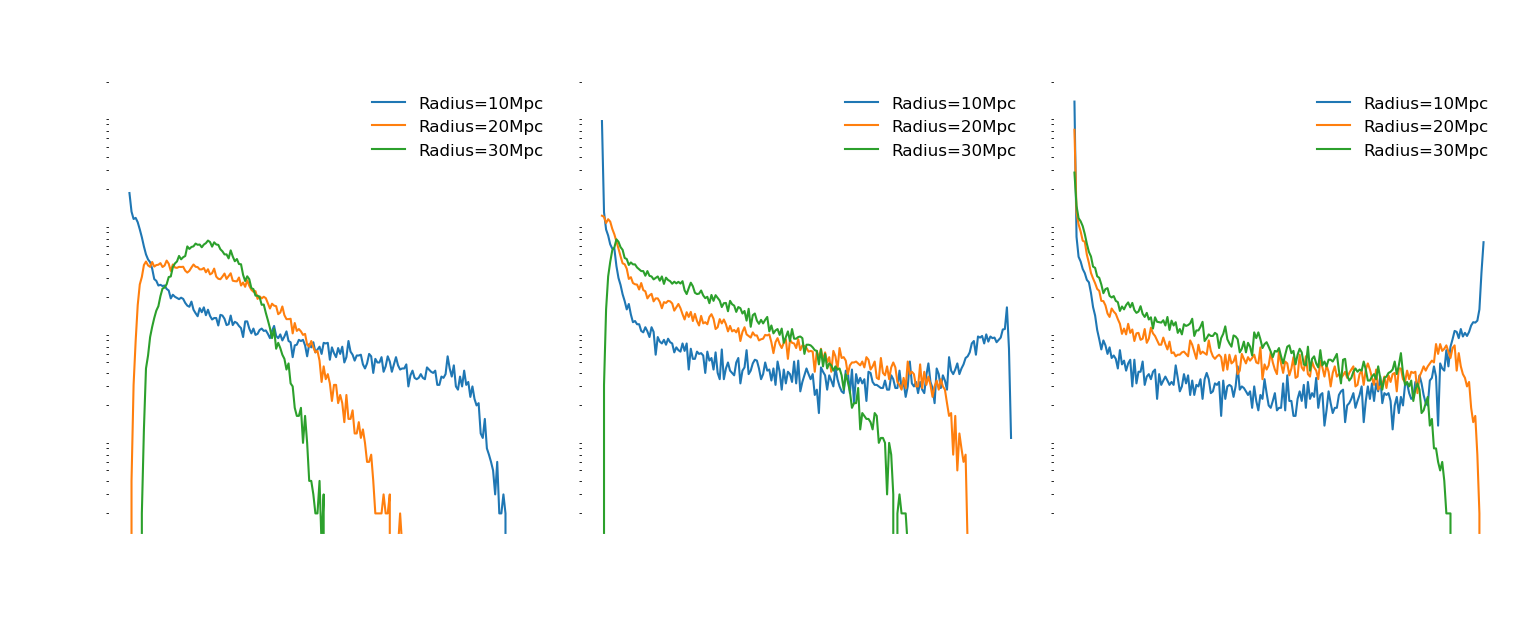

In [43]:
radii=[10, 20, 30]
bins = int(2e2)
histogram(
    y1s=neutral_spheres_statistics,       
    marker_lines=['-']*len(radii),
    y1s_labels=[f'Radius={radius:d}Mpc' for radius in radii],
    legend_alpha=0,
    bin_num=bins,   
    title=[f'radius={radii[i]:d}, {iterations[i]:d}spheres, x_HI={x_HI*100:.2f}%' for i,
           x_HI in enumerate(overall_neutral_fractions[:-1])],
    shared_title=f'Distribution of Average Neutral Fraction \
of Neutral Spheres Boxes ({bins:d} bins, {distribution_iterations:d}iterations)',
    shared_title_y_position=1,
    shared_y_label='Counts',
    shared_x_label='Neutral Fraction',
    shared_x_label_y_position=0,
    figure_shape=(1,3), 
    figure_size=(18,6),
    vertical_gap=0.1,
    horizontal_gap=0.05,
    y_scale='log',
#     y_notation='sci',
    share_y_axis=True,
#     dpi=1000
)

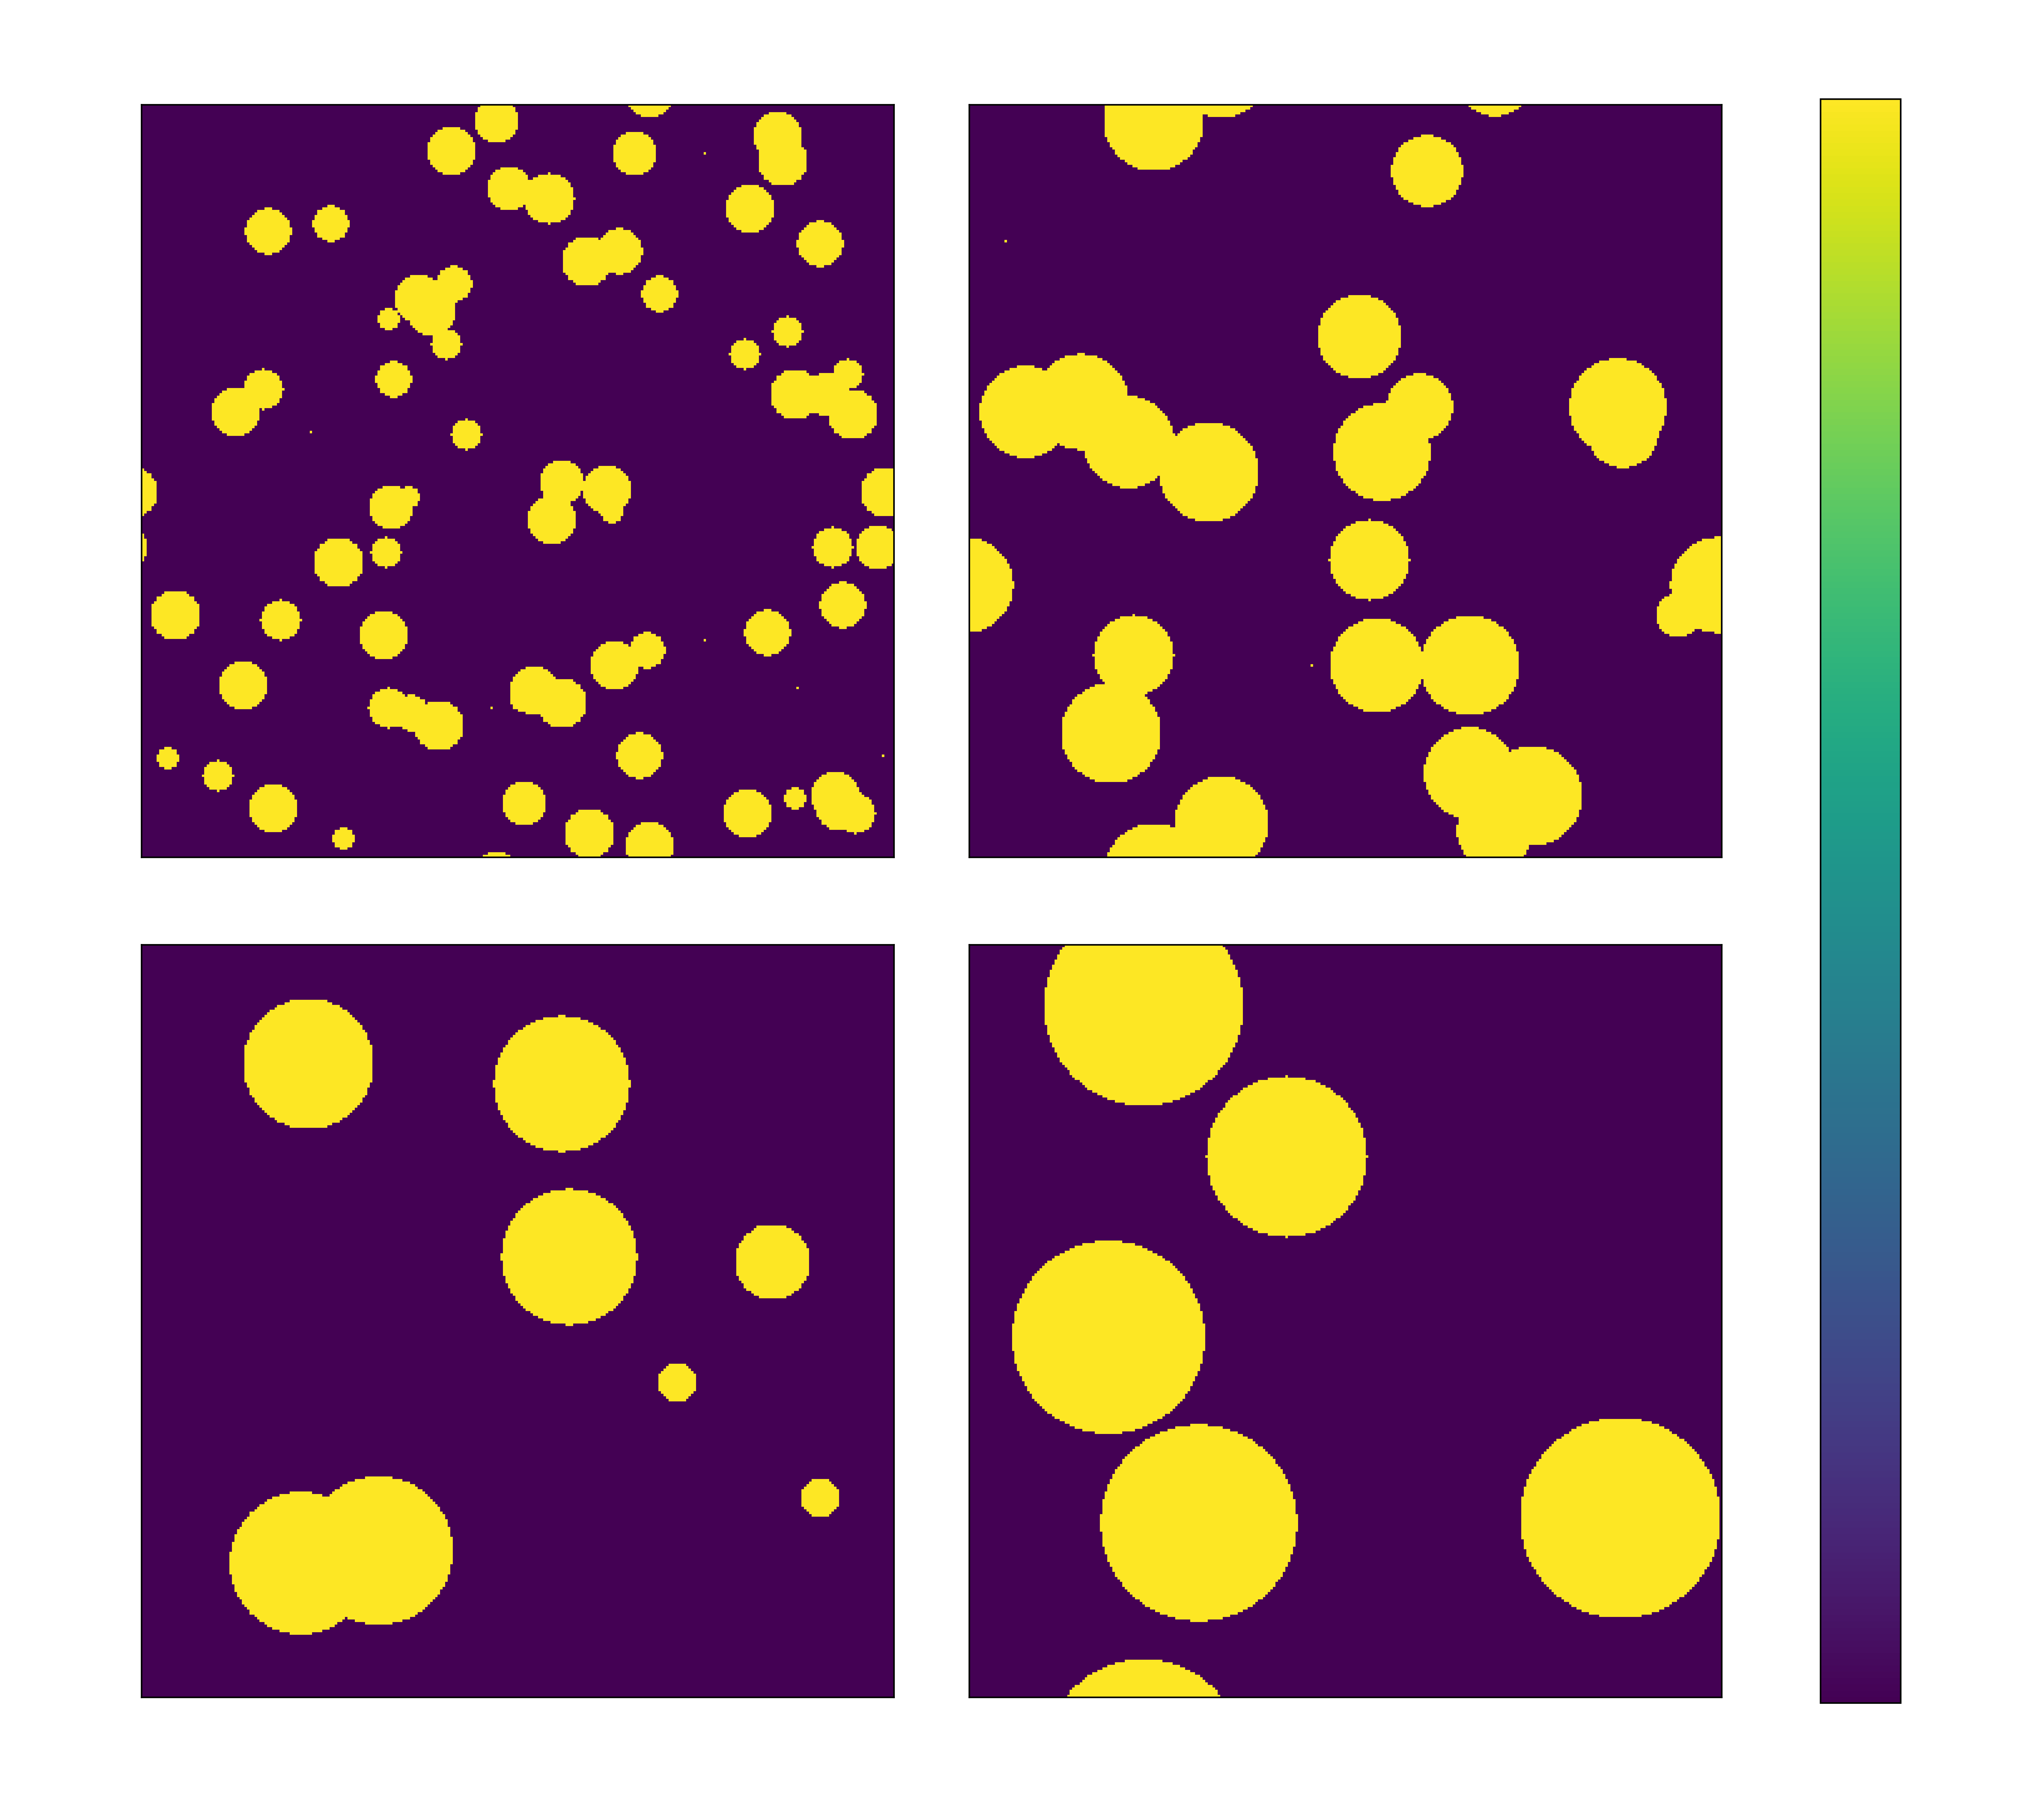

In [159]:
slices_plots(
    boxes=neutral_spheres_boxes,
    titles=[f'radius={radius:d}, \
{iterations[i]:d}spheres, \
x_HI={overall_neutral_fractions[i]*100:.2f}%\
' for i, radius in enumerate(sphere_radii)],
    color='w',
    figure_shape=[2, 2],
    figure_size=(18, 15),
    shared_title='Neutral Spheres Boxes',
    font_size=18,
    shared_title_x_position=0.43,
    shared_y_label_x_position=0.075,
    dpi=500
)

Text(0, 0.5, 'Mpc')

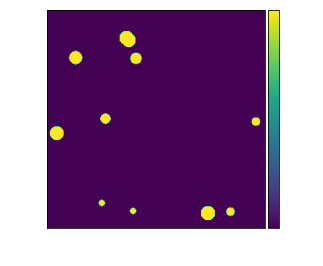

In [87]:
# plt.figure(dpi=500)
color='w'
im = plt.imshow(
    neutral_spheres_box[150, :, :], 
    extent=(0,np.shape(neutral_spheres_box)[1],0,np.shape(neutral_spheres_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

In [36]:
illustration_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond,
).xH_box

2020-12-16 15:23:42,173 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


Text(0, 0.5, 'Light-year')

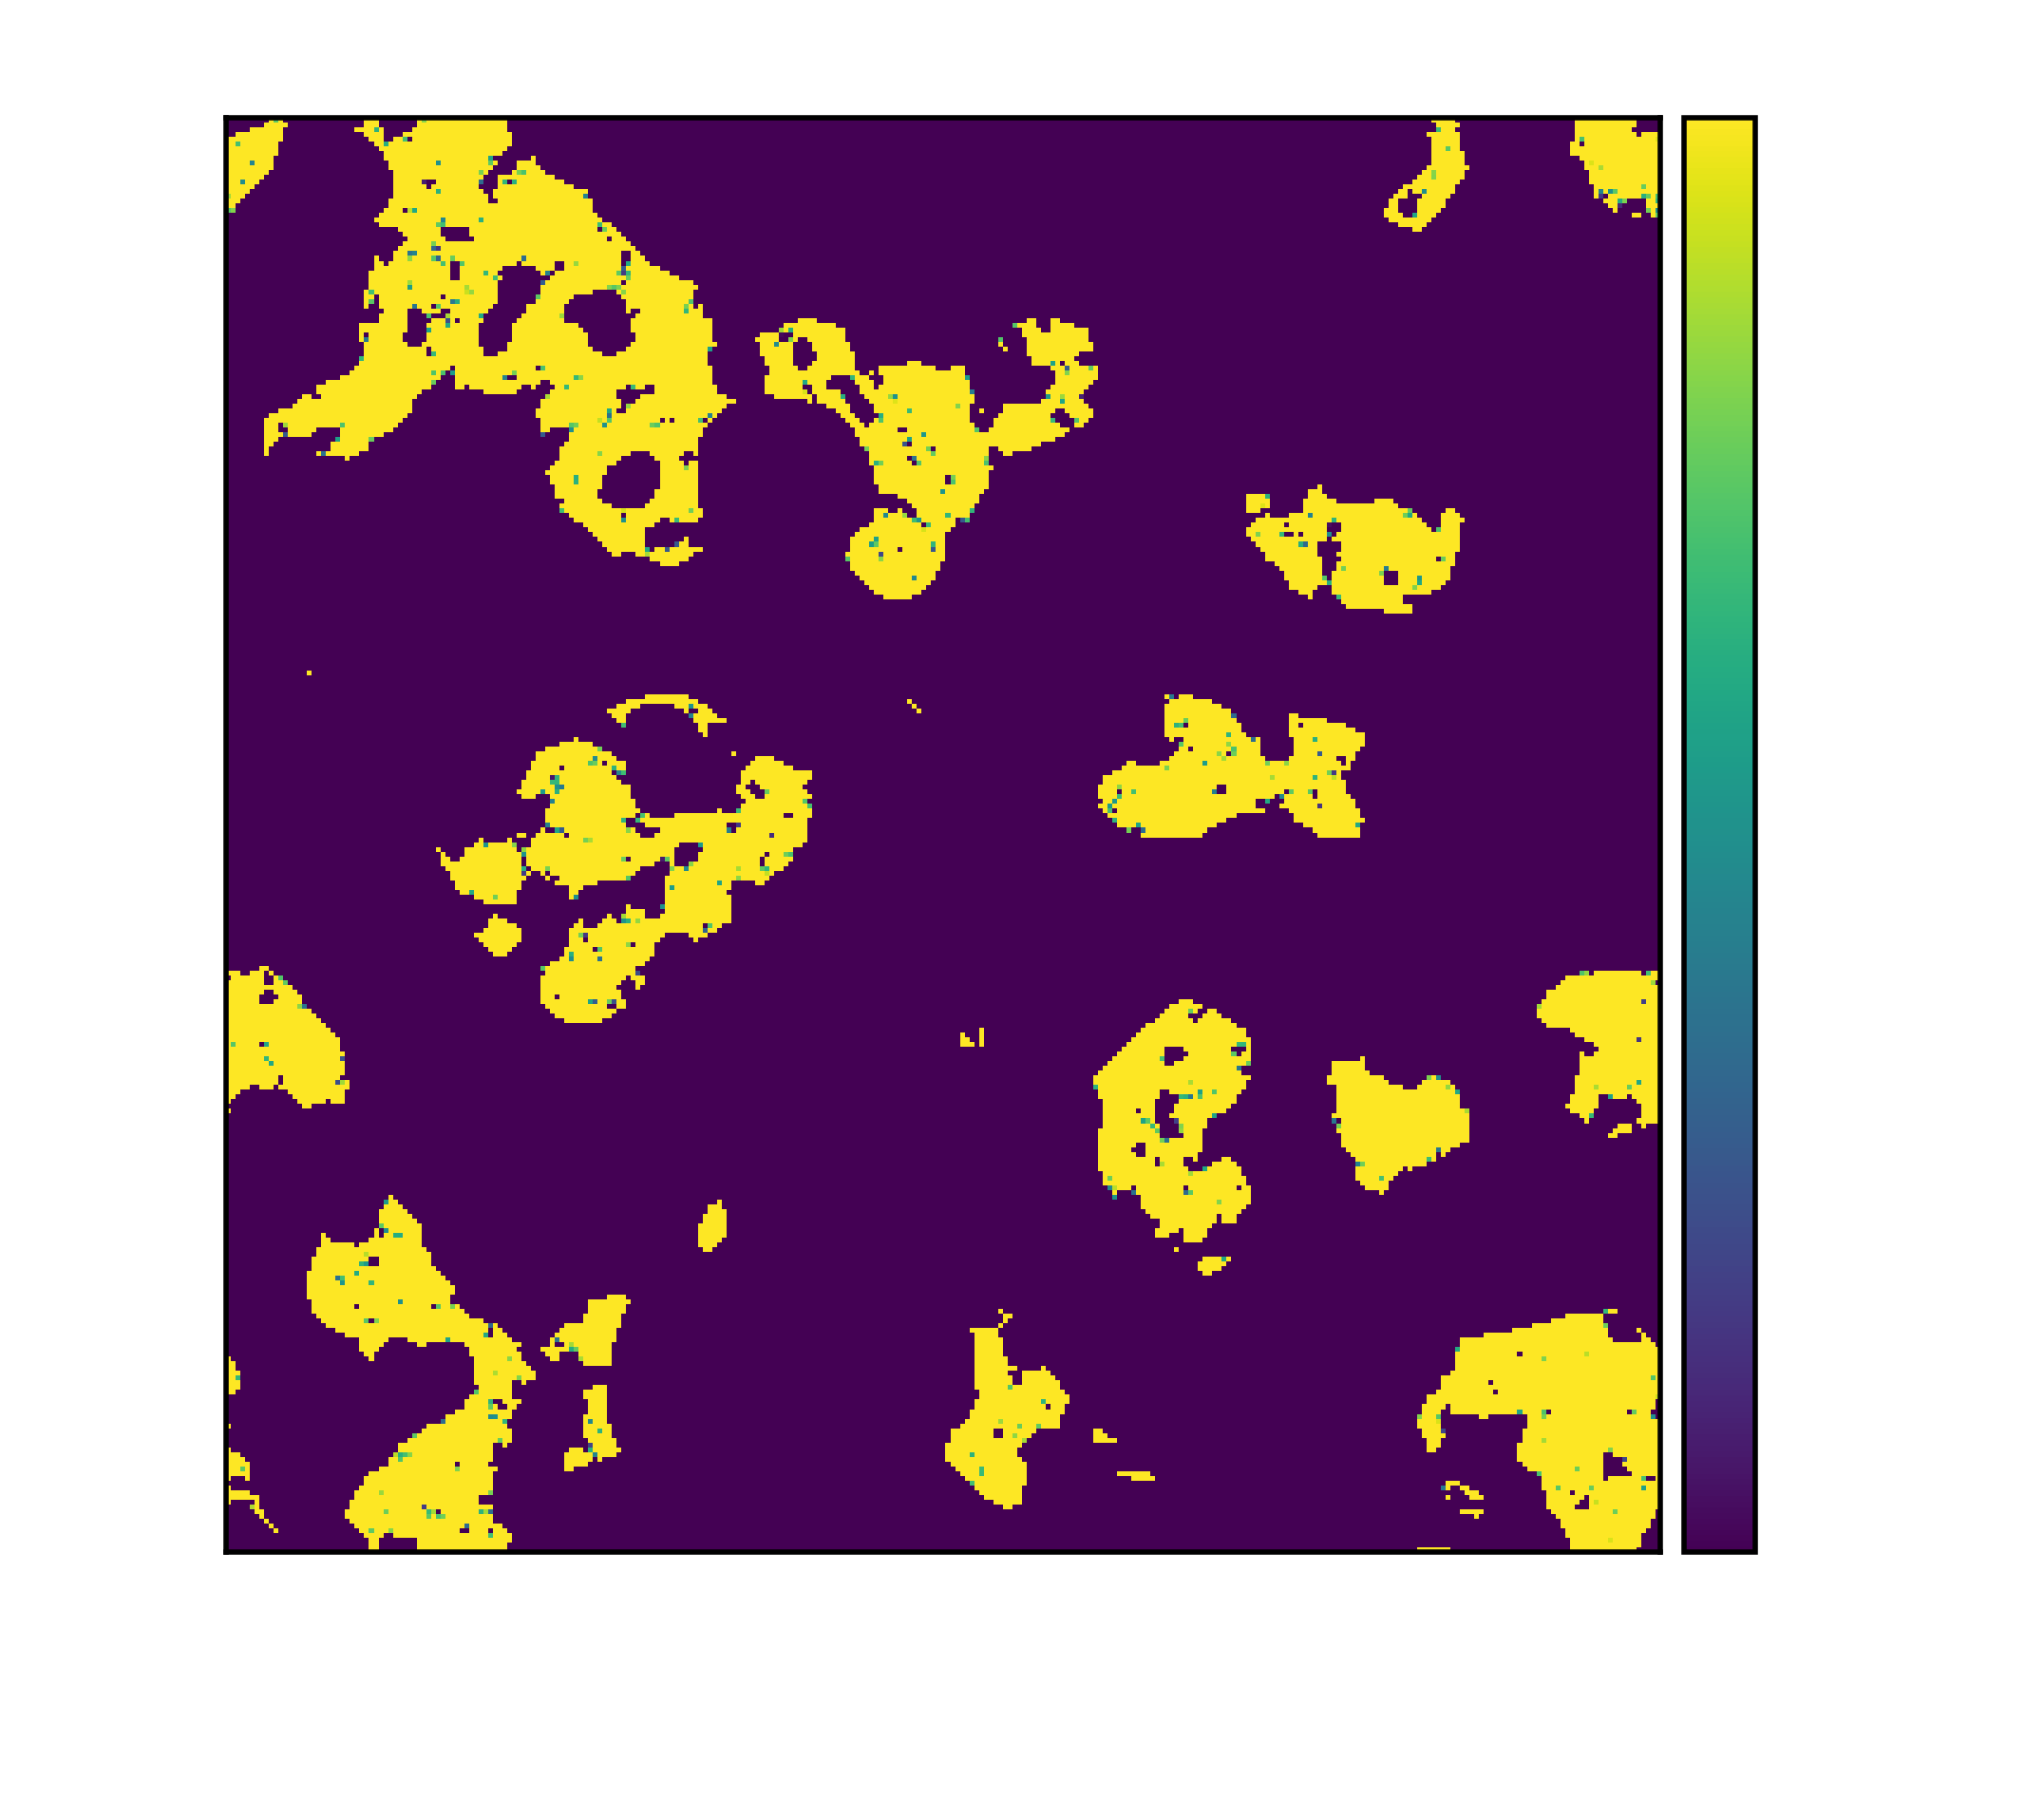

In [37]:
plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_box[150, :, :], 
    extent=(0,np.shape(illustration_box)[1]*3.262e+6,0,np.shape(illustration_box)[2]*3.262e+6), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Light-year', color=color)
plt.ylabel('Light-year', color=color)

In [84]:
redshifts

array([13, 12, 10,  9,  8,  7,  6,  5])

In [80]:
np.shape(ionized_boxes)

(8, 301, 301, 301)

In [81]:
np.shape(ionized_boxes[0, 150, :, :])

(301, 301)

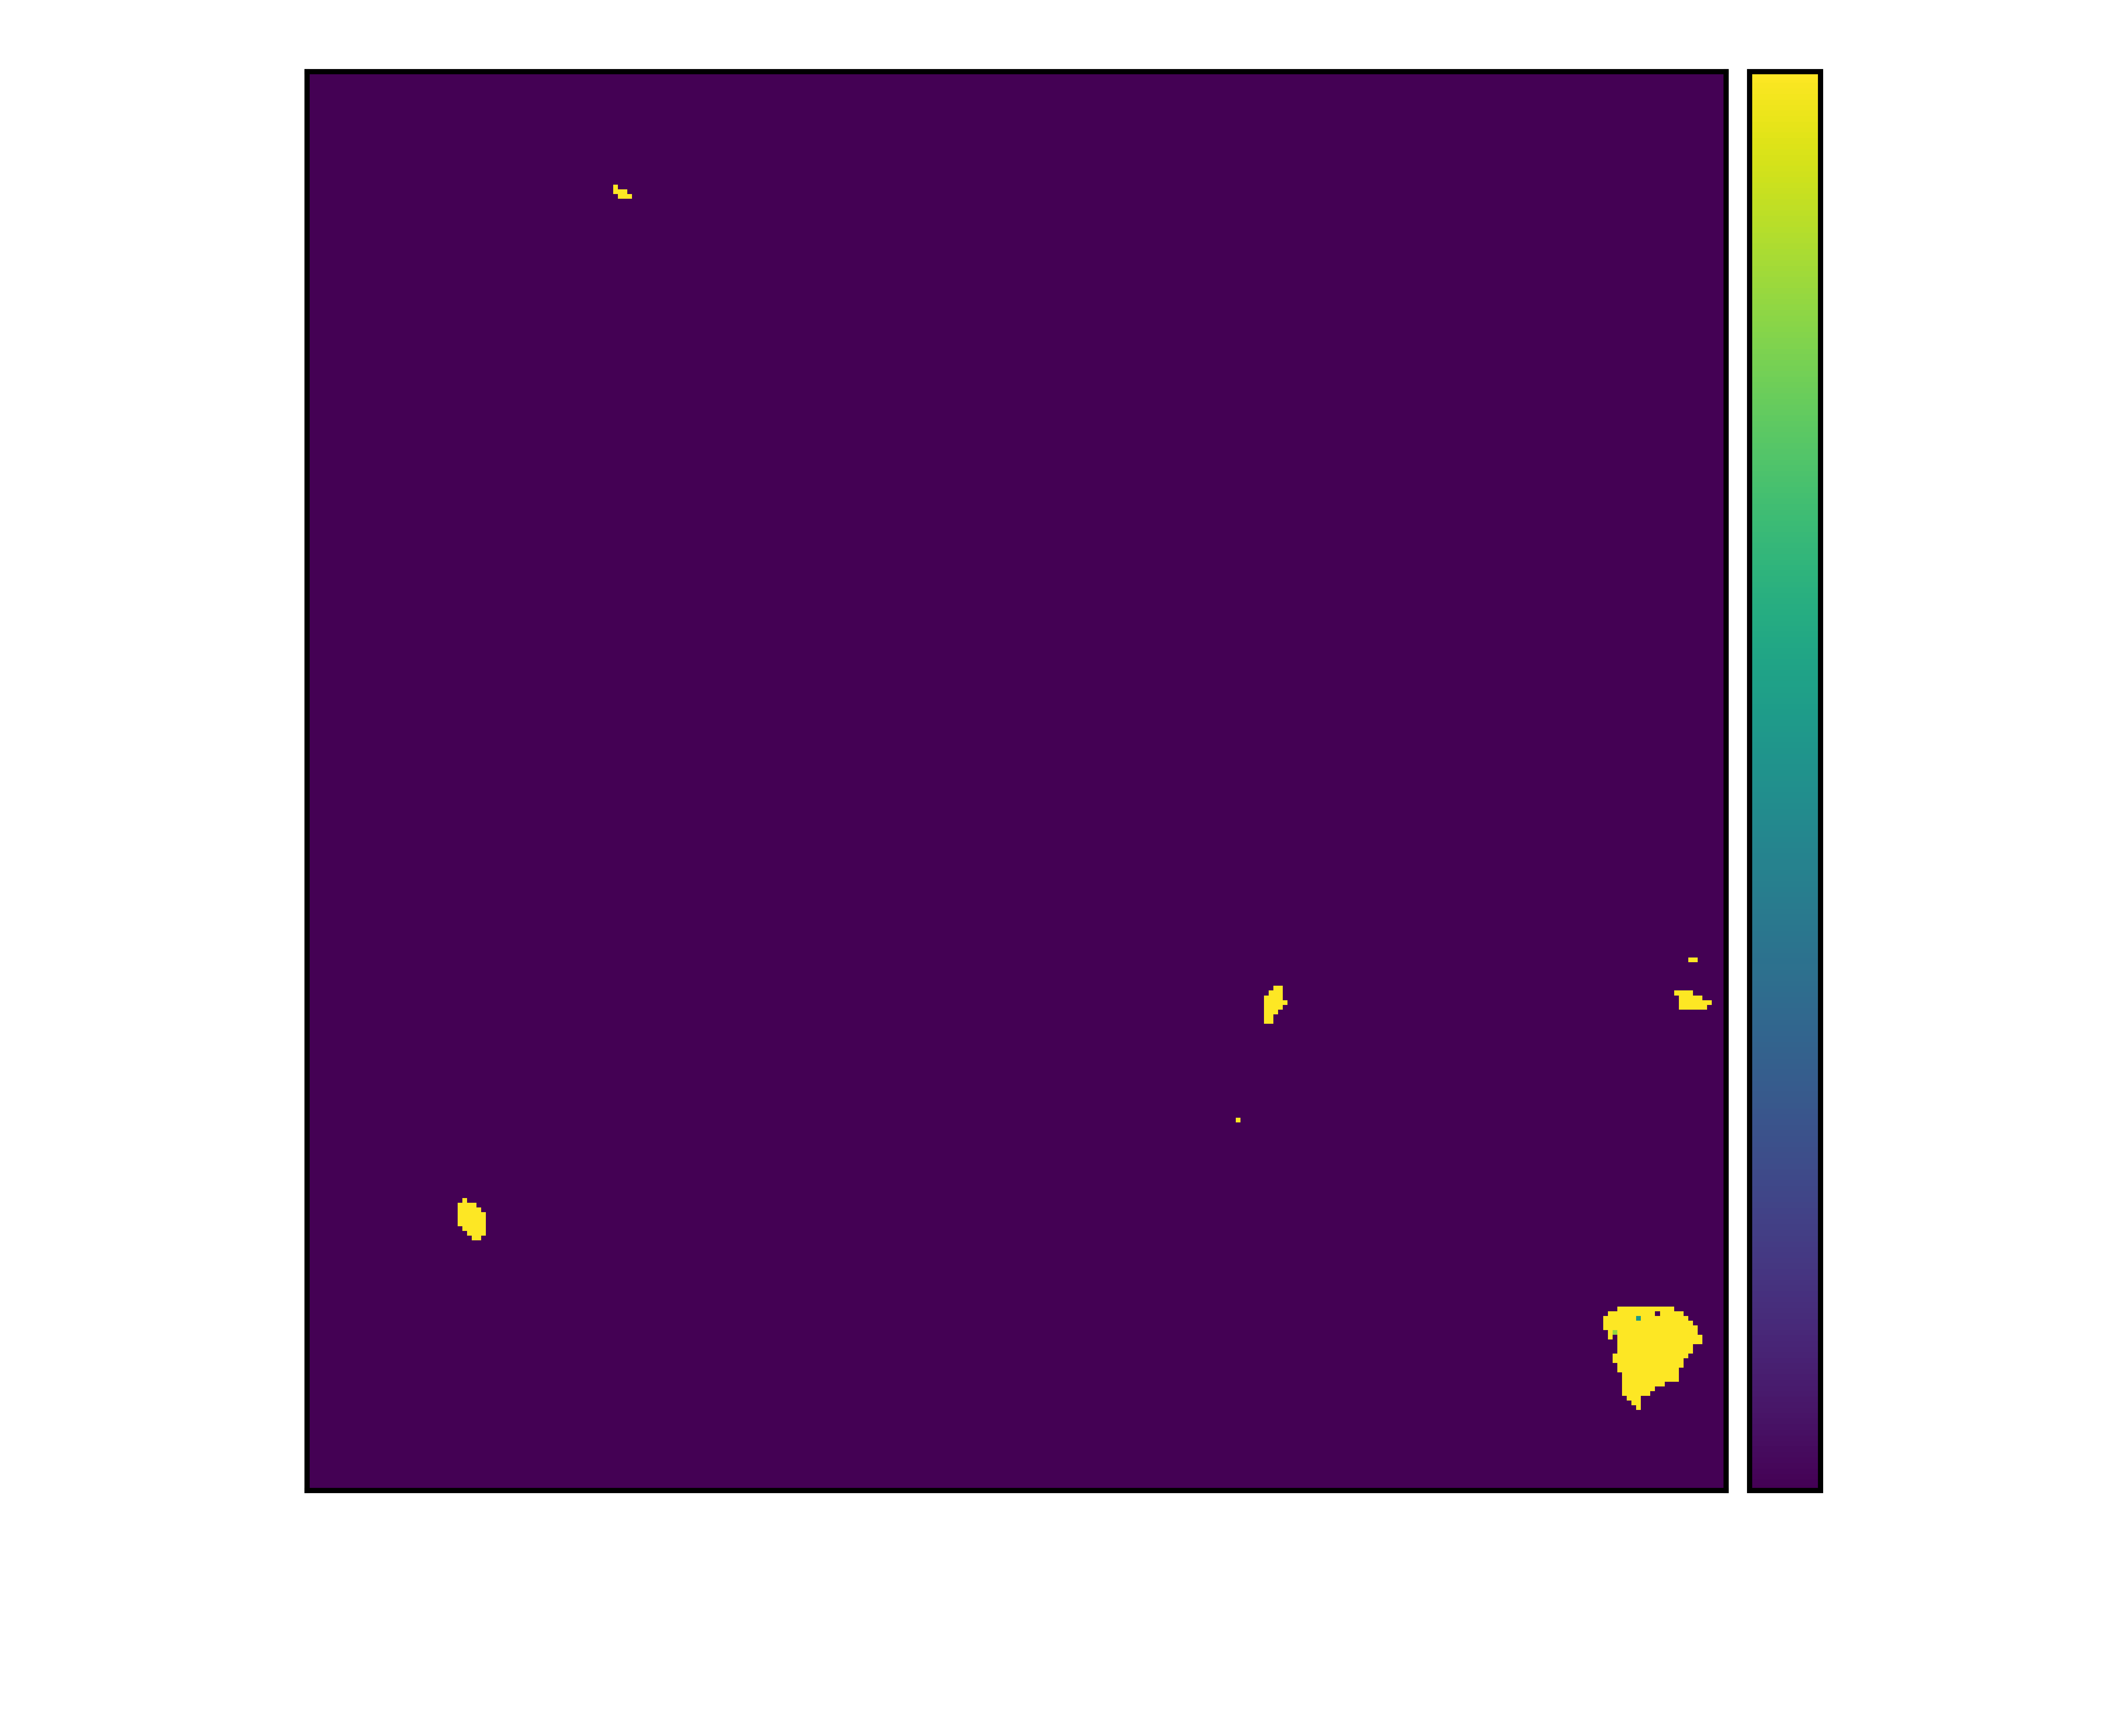

In [103]:
b = 7

plt.figure(dpi=1000)
color='w'
im = plt.imshow(
    ionized_boxes[b, 150, :, :], 
    extent=(0,np.shape(ionized_boxes[b, 150, :, :])[0],0,np.shape(ionized_boxes[b, 150, :, :])[1]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

Text(0, 0.5, 'Mpc')

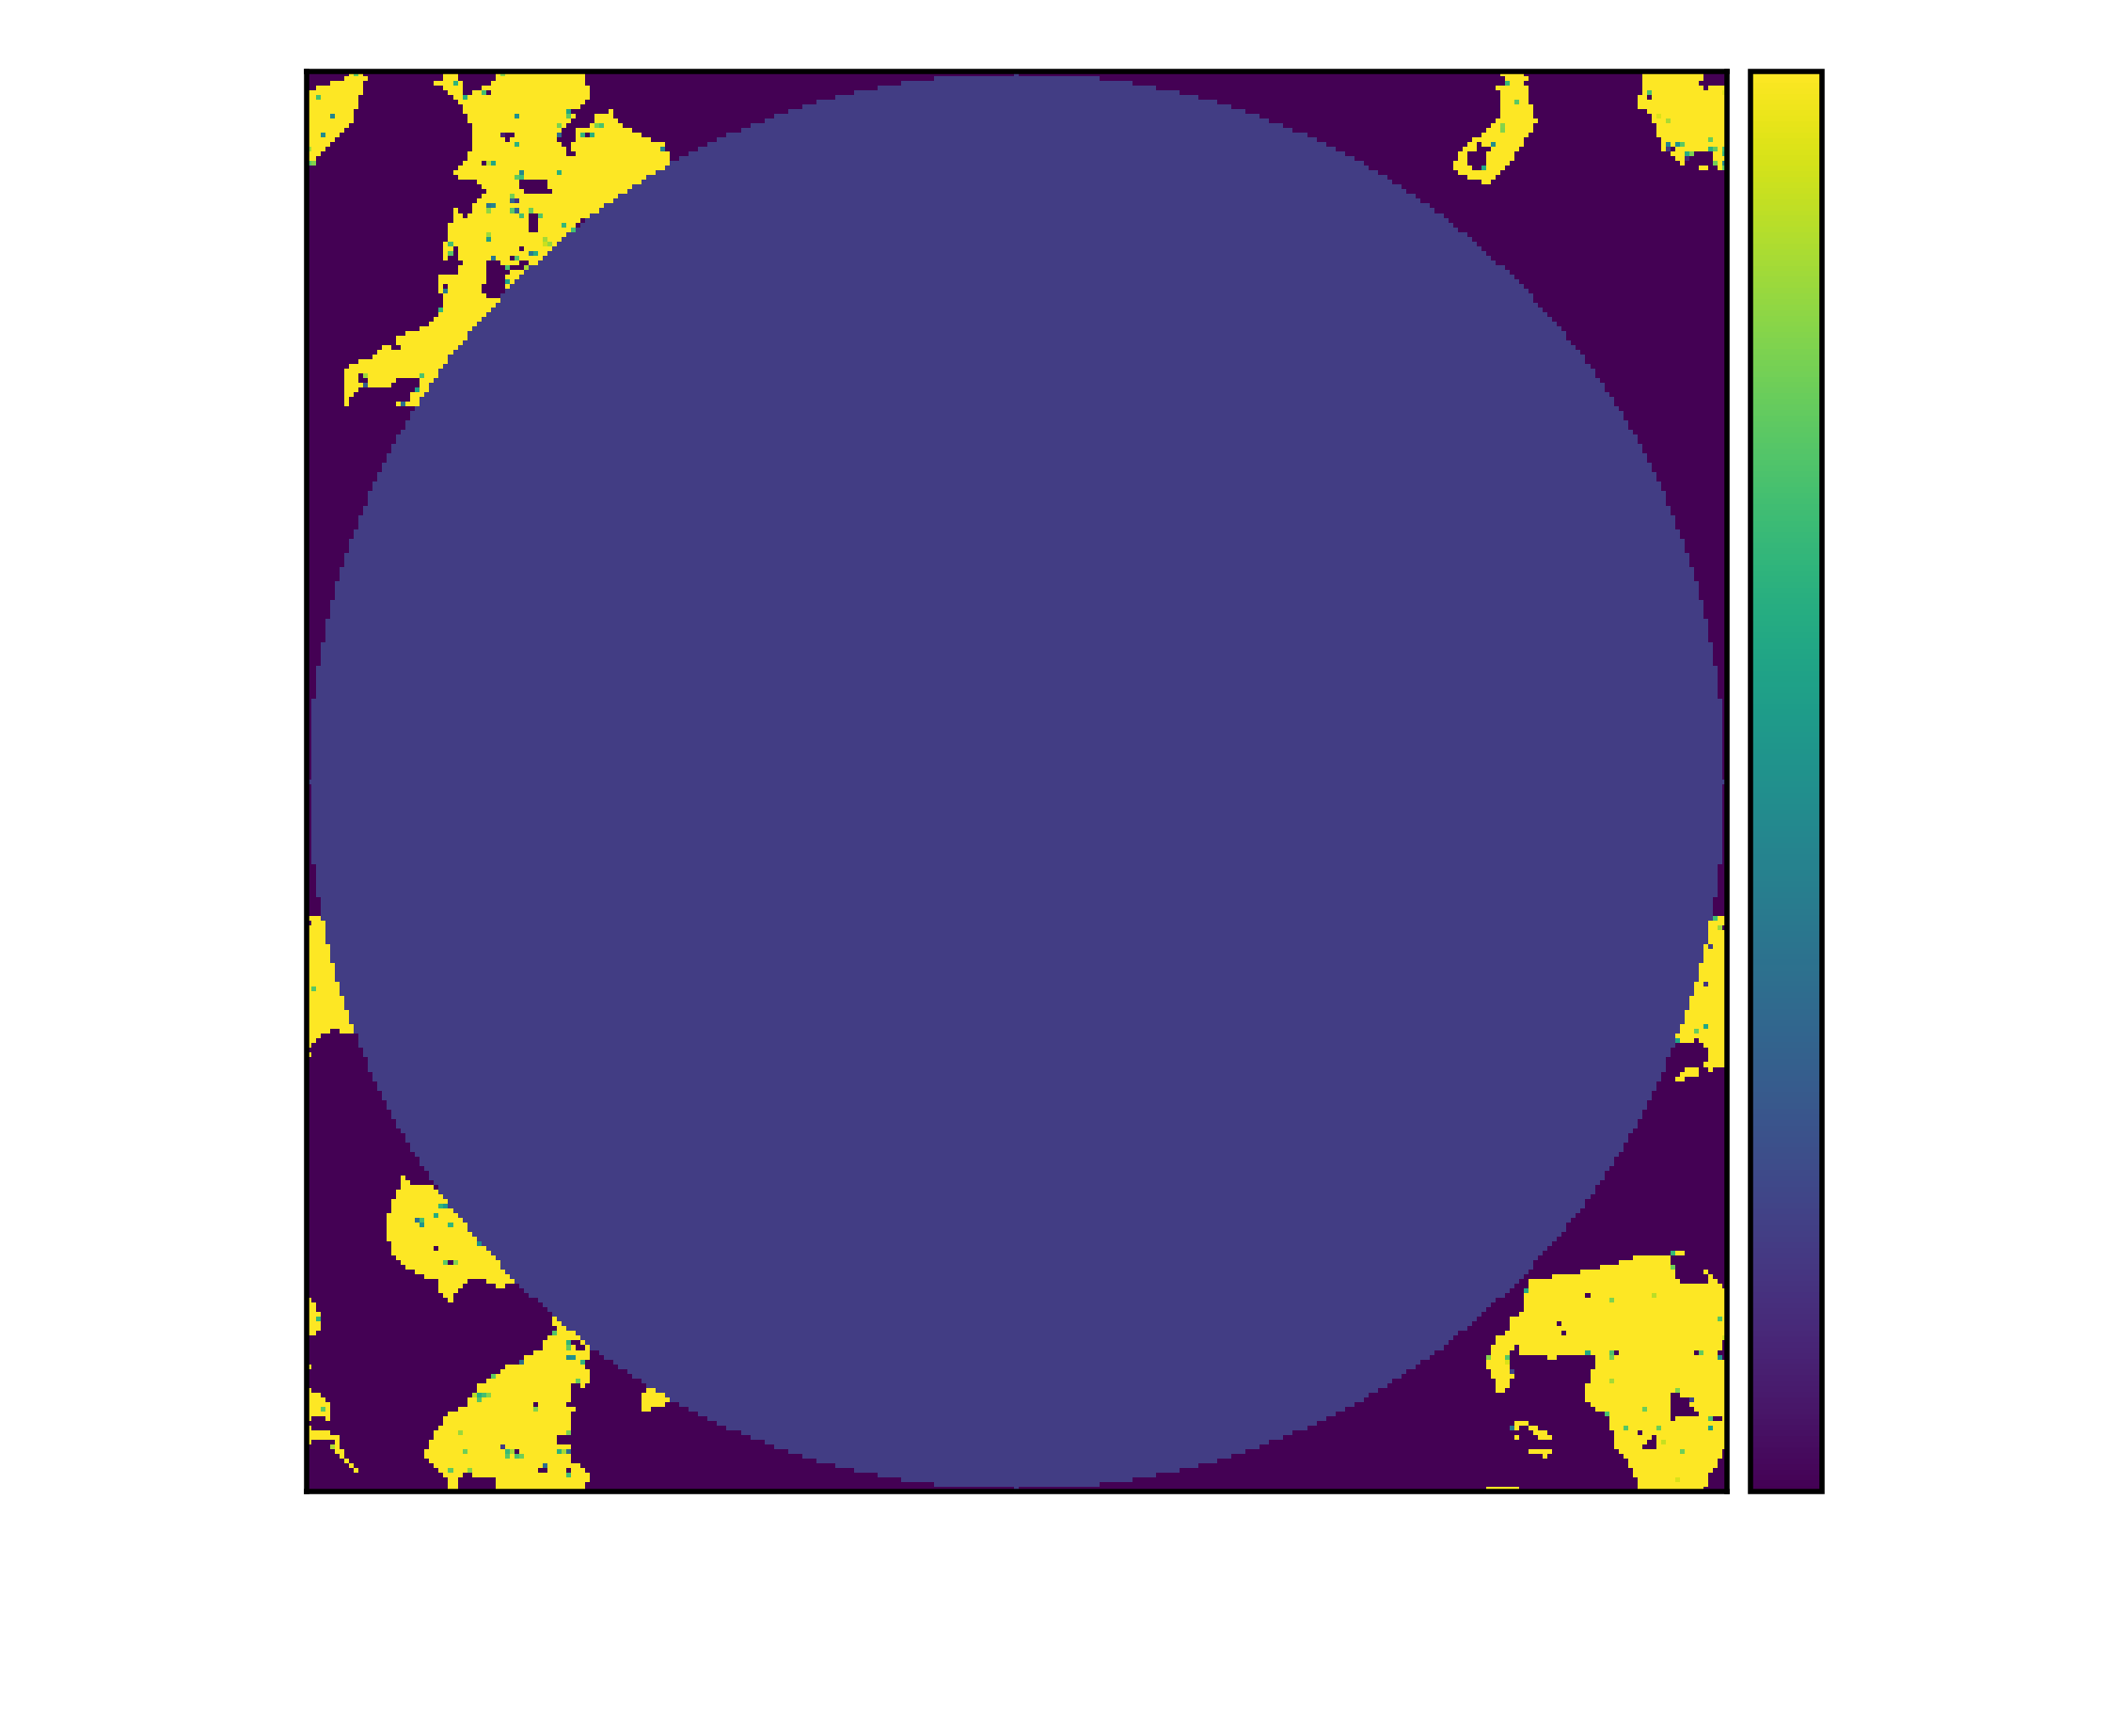

In [118]:
illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=150,
    coordinates=np.array([150,150,150])
)

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

Text(0, 0.5, 'Mpc')

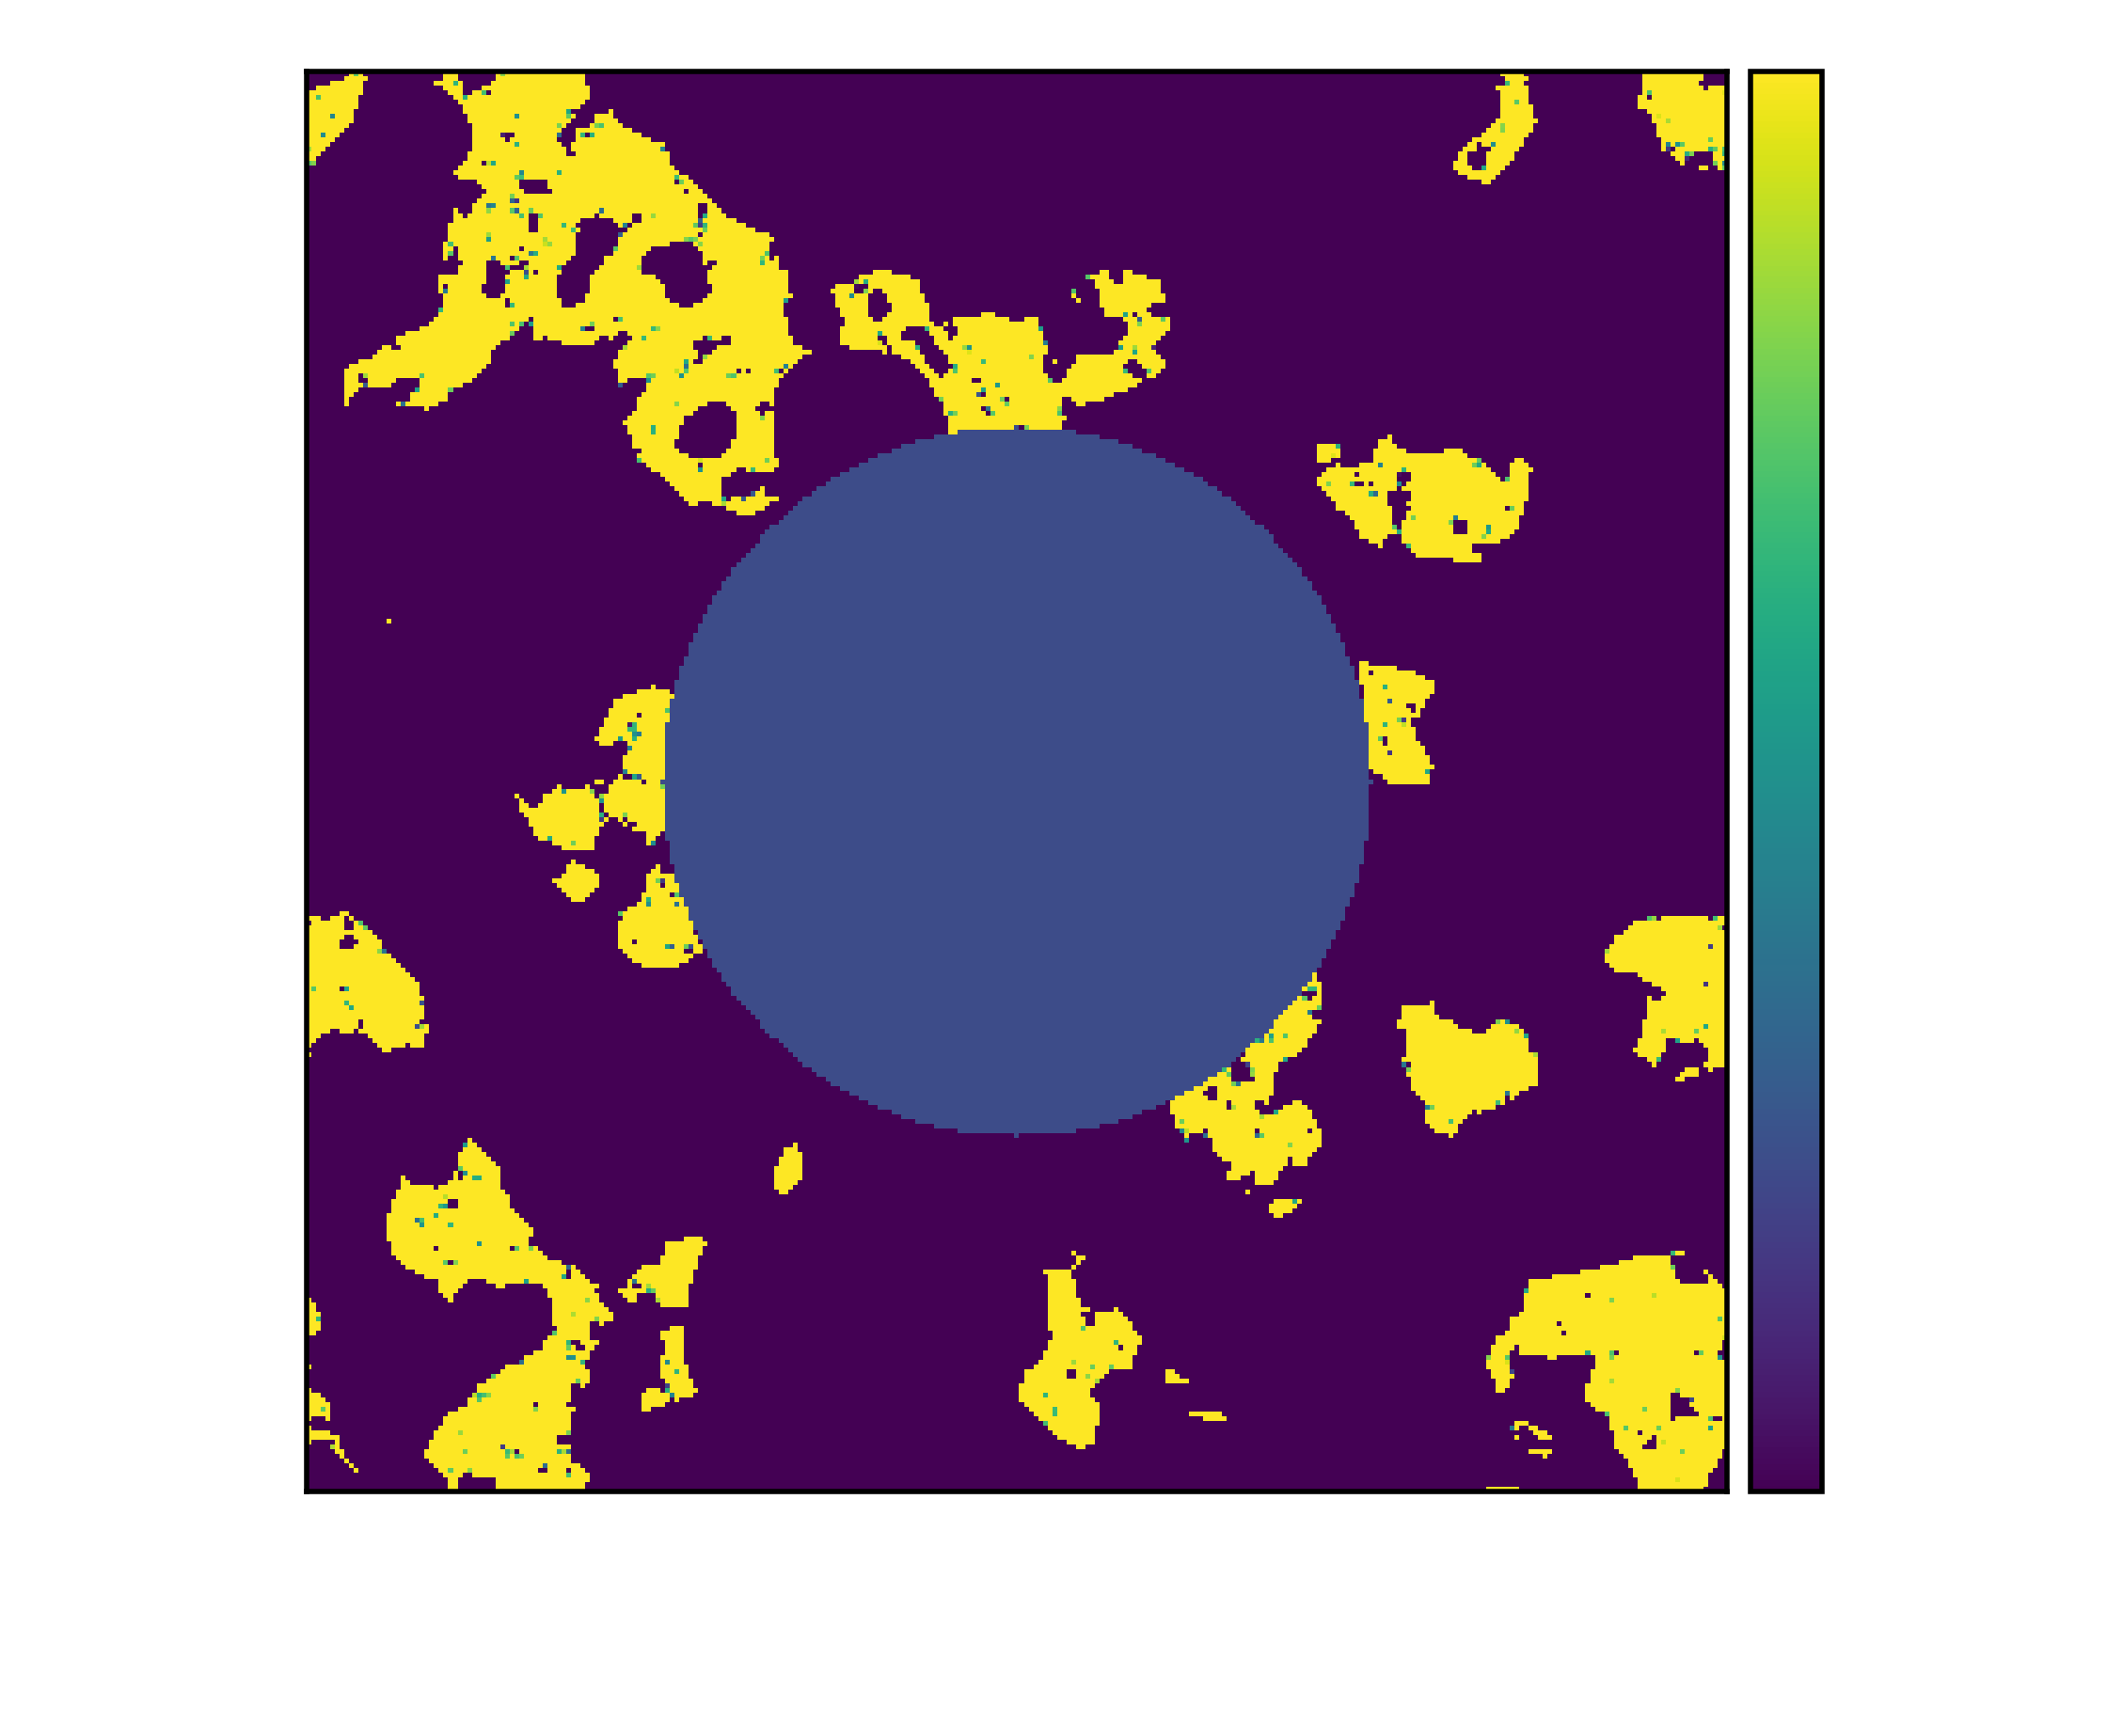

In [119]:
illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=75,
    coordinates=np.array([150,150,150])
)

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

Text(0, 0.5, 'Mpc')

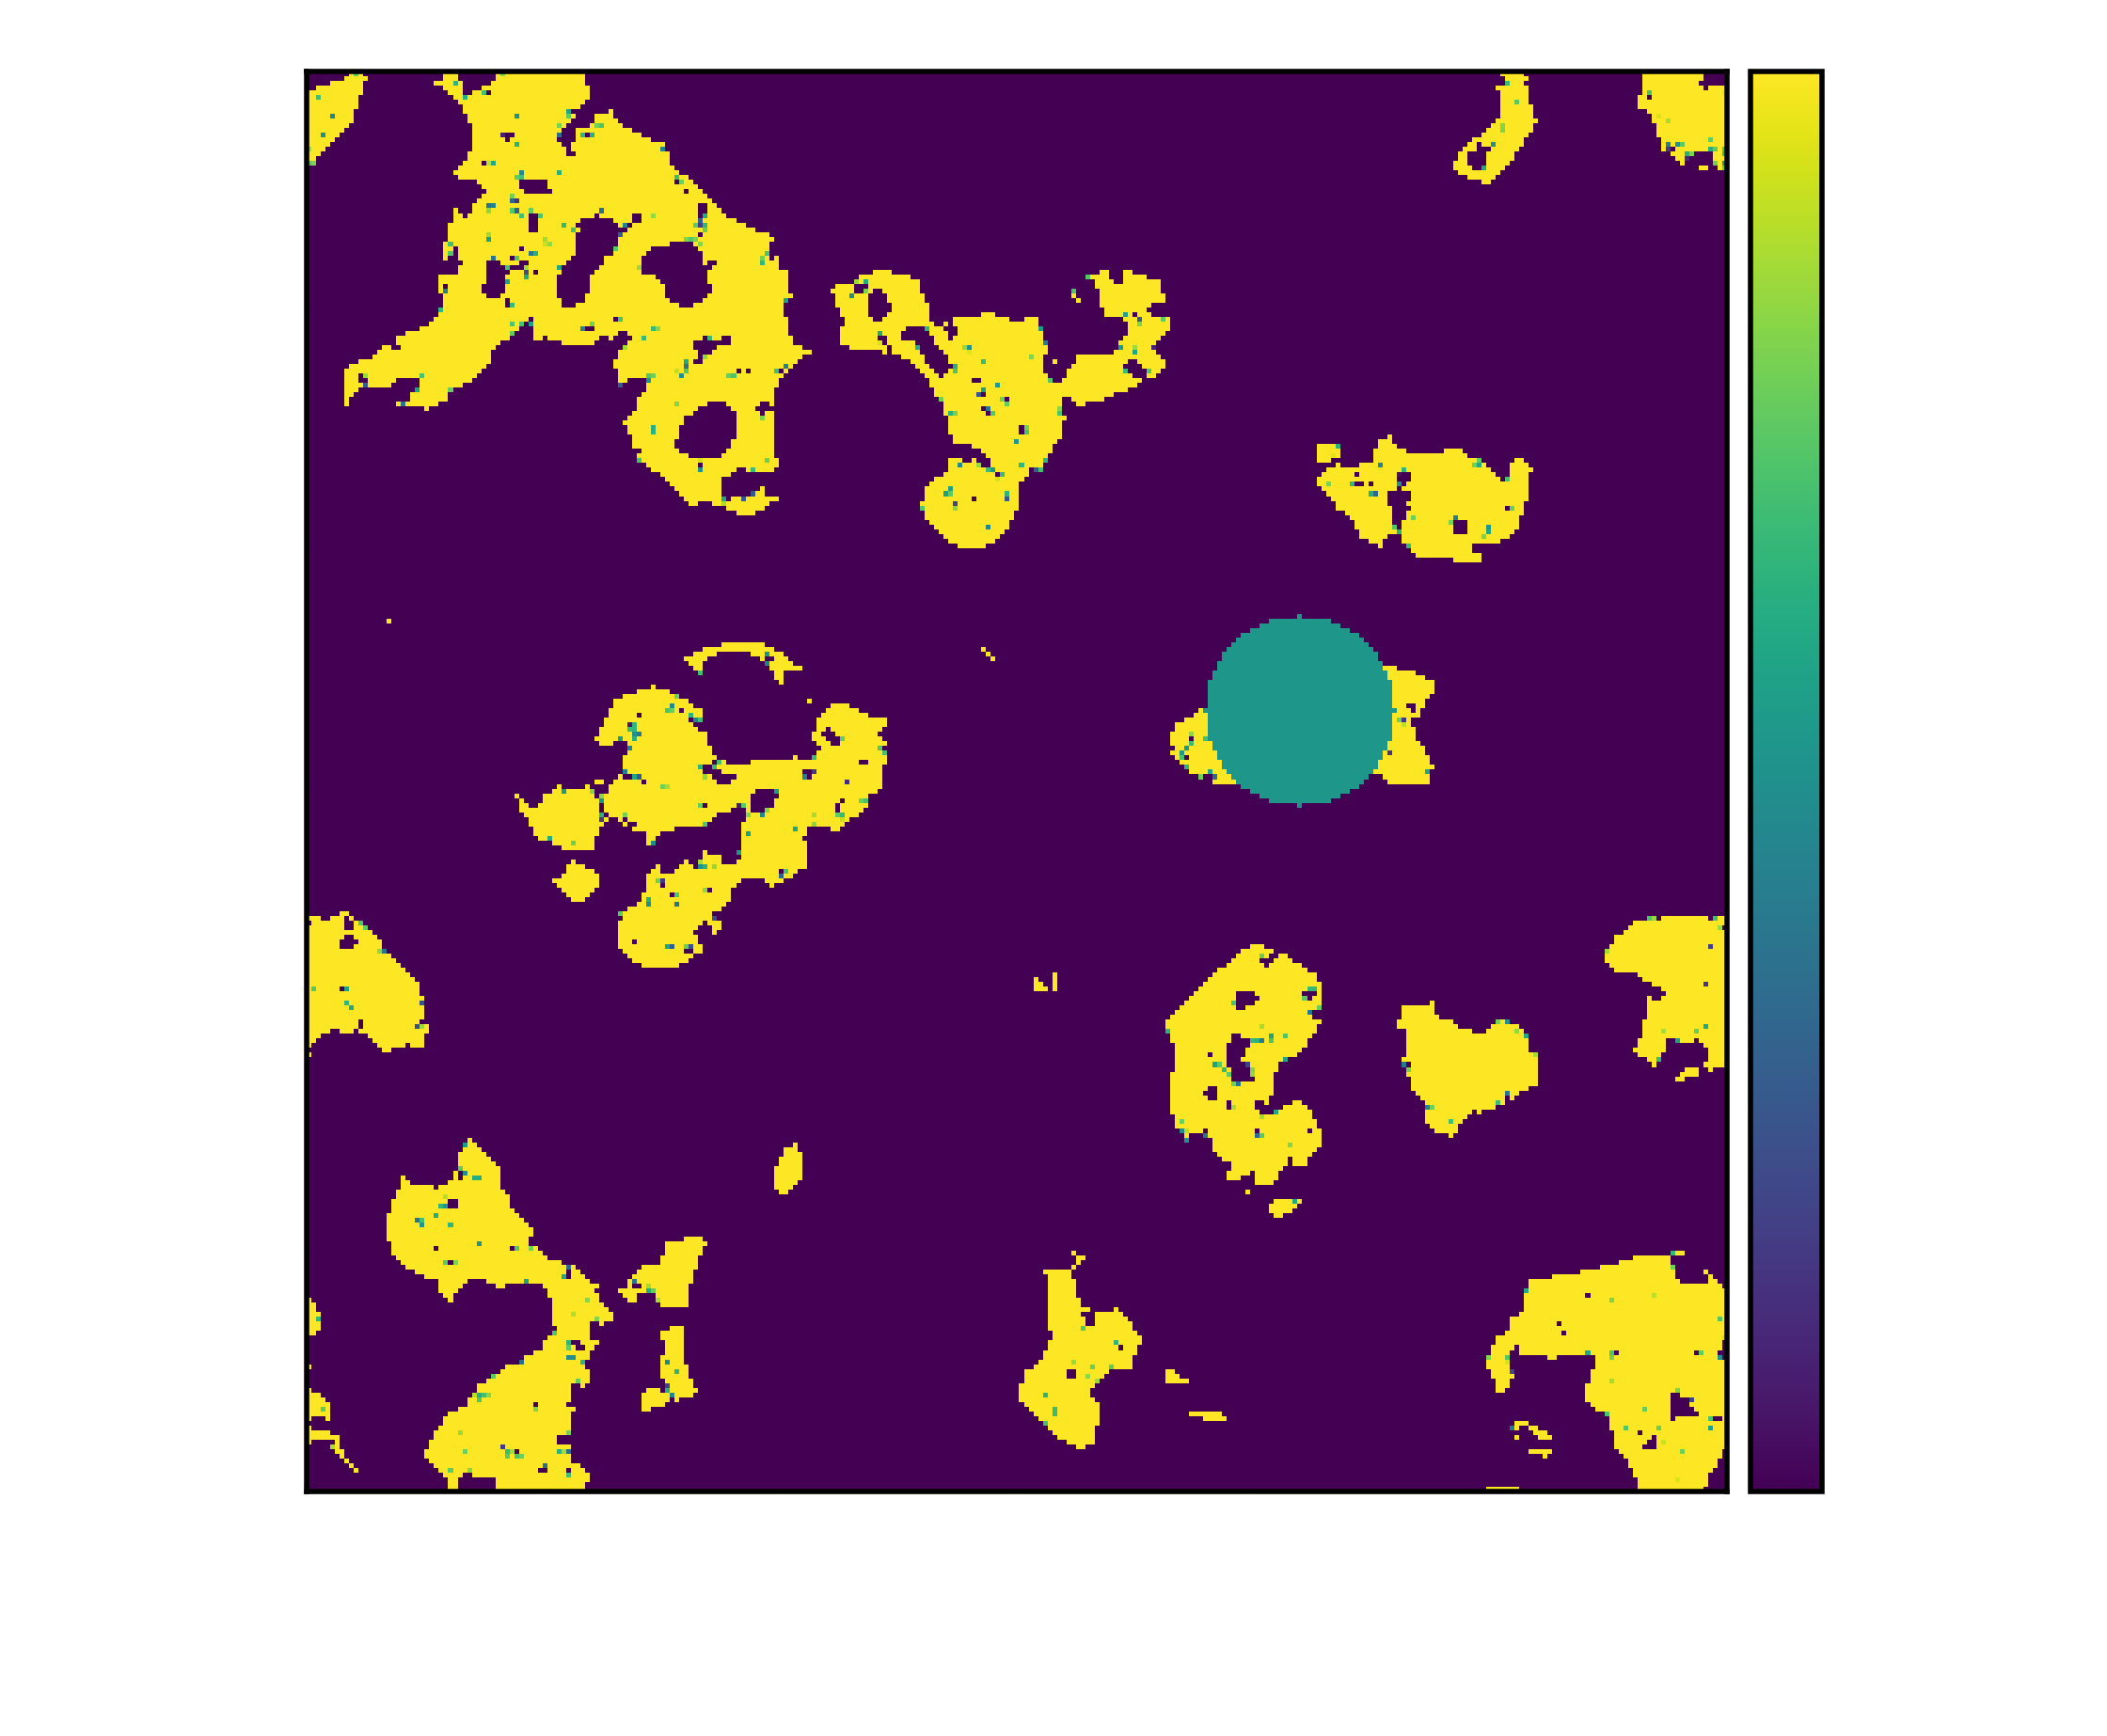

In [122]:
illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=20,
    coordinates=np.array([150,165,210])  # z, y, x
)

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

Text(0, 0.5, 'Mpc')

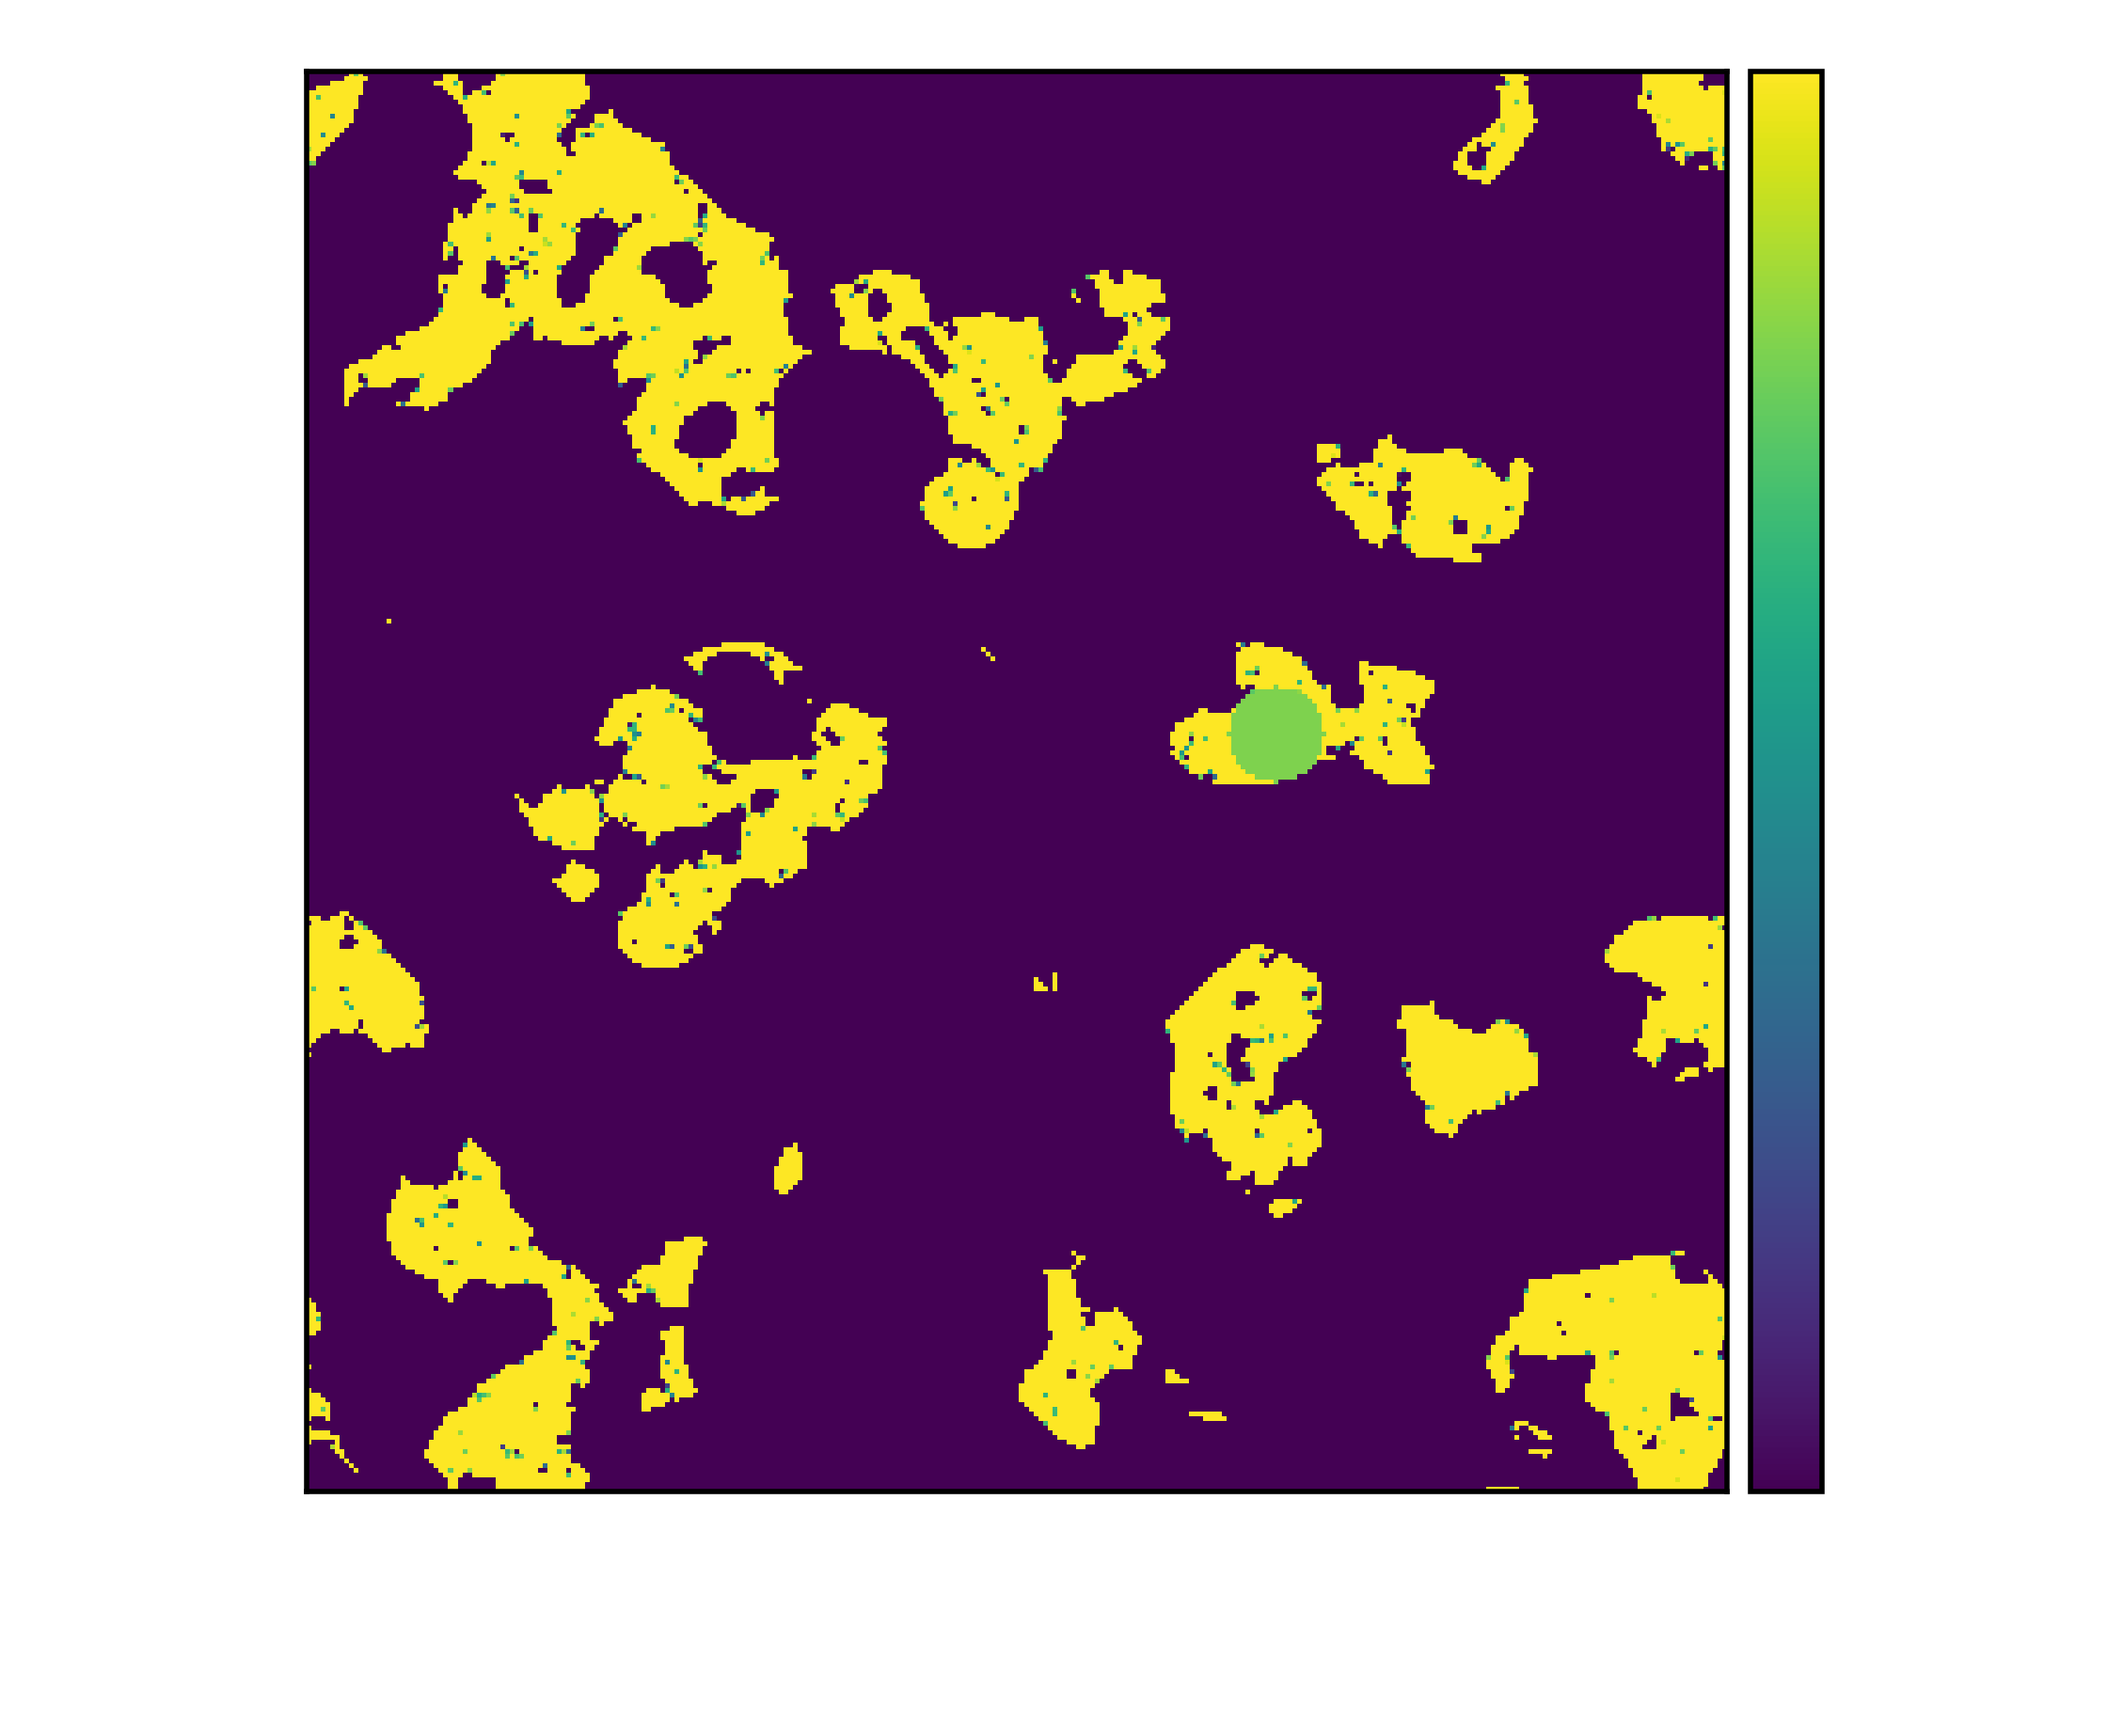

In [123]:
illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=10,
    coordinates=np.array([150,160,205])  # z, y, x
)

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

Text(0, 0.5, 'Mpc')

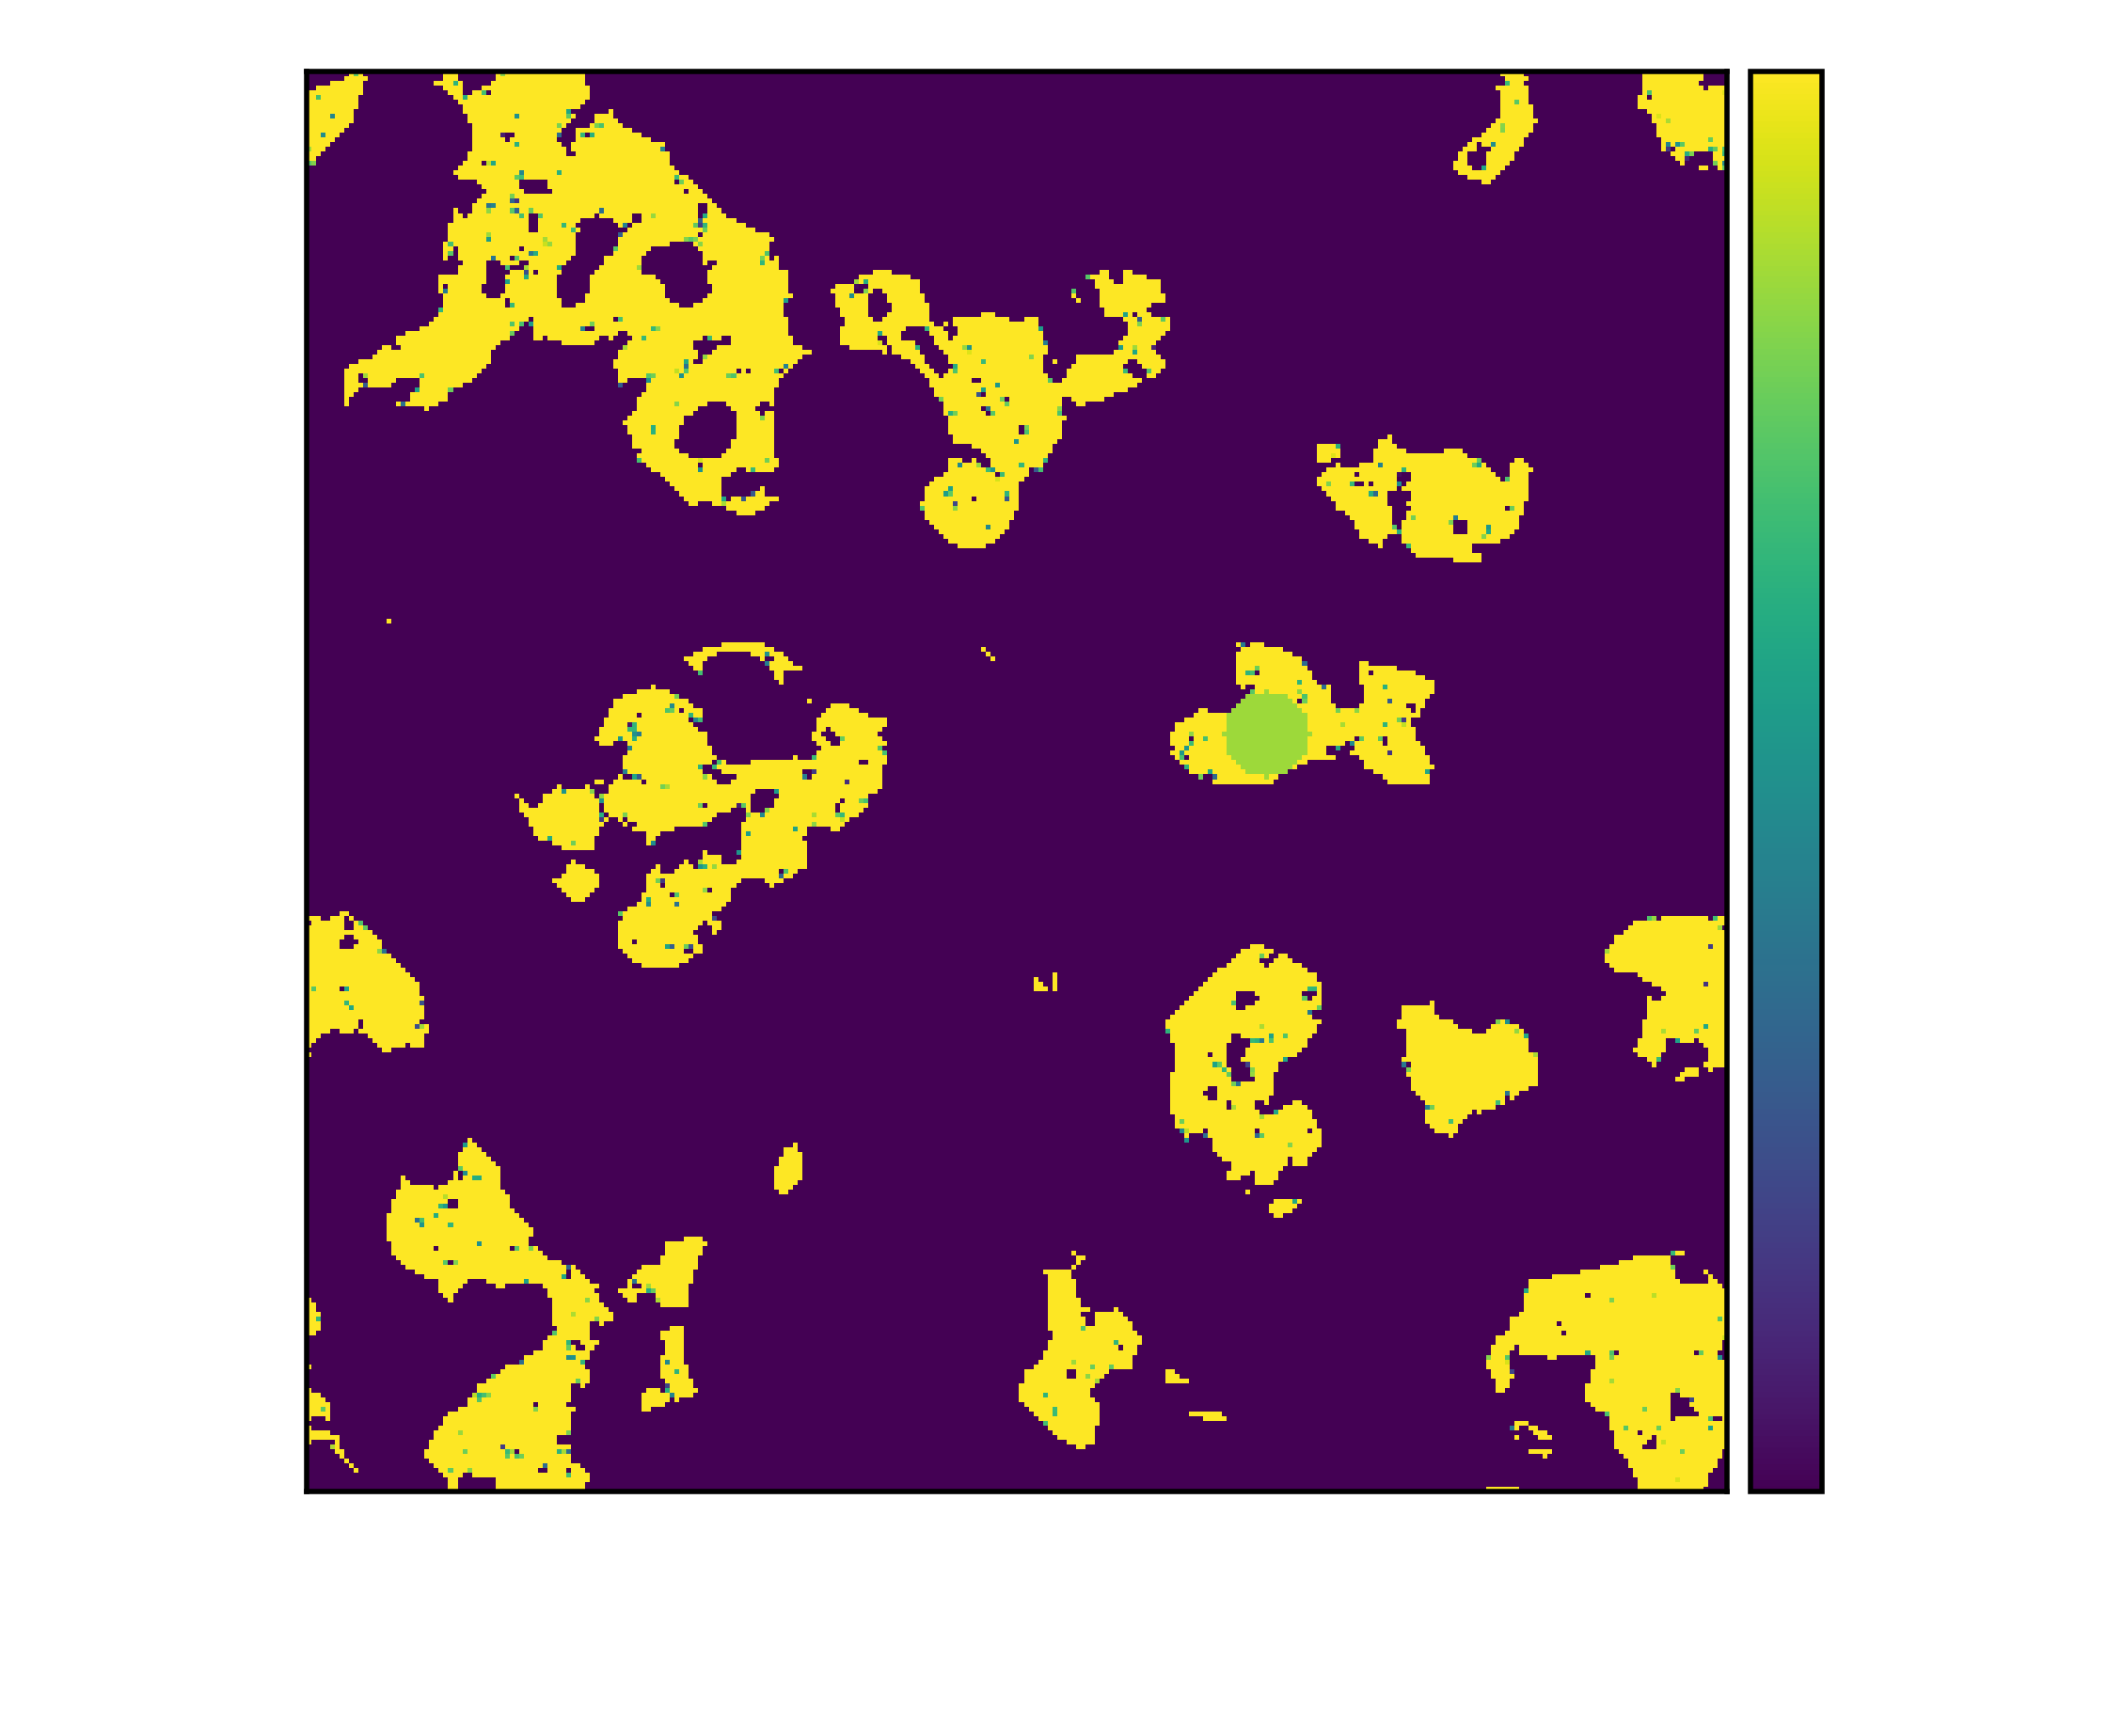

In [154]:
illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=9,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=500)
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(box)[1],0,np.shape(box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)

## Generate Average Neutral Fraction Distributions as a function of redshift

In [35]:
def generate_distributions(
    boxes,
    radii=np.arange(8, 17, 1),
    iterations=int(10**3),
    sigma_factor=1.4370397097748921*3,
    shell_number=6,
    progress_status=True
):

    gaussians = np.zeros((len(boxes), len(radii), iterations))
    
    # print progress and local time
    if progress_status:
        start_time = datetime.now()
        current_time = start_time
        print(f'Progress = 0%, localtime = {start_time}')

    for i, box in enumerate(boxes):
               
        for ii, radius in enumerate(radii):
                        
            gaussians[i, ii, :] = average_neutral_fraction_distribution(
                box=box,
                radius=radius,
                iteration=iterations,
                sigma_factor=sigma_factor,
                shell_num=shell_number,
                blur_shape='Gaussian_sphere'
            )
        # print progress and local time
        if progress_status:
            previous_time = current_time
            current_time = datetime.now()
            loop_time = current_time - previous_time
            elapsed_time = current_time - start_time
            print(f'progress = {int(round((i+1)*100/len(boxes)))}%, \
localtime = {current_time}, loopexecuted in {loop_time}, elapsedtime = {elapsed_time}')
    
    return gaussians

## Generate the distributions and storing the data in global variables

In [ ]:
radii = np.arange(9, 1, -1)  # array([34, 32, 30,... 6, 4]) units: voxels (51, 3, -3)
iterations = int(1e5)

gaussians = generate_distributions(
    boxes=ionized_boxes,
    radii=radii,
    iterations=iterations,
    sigma_factor=1.4370397097748921*3
)

In [ ]:
gaussians = np.load('/users/wchin/gaussians.npy')
radii = np.arange(9, 1, -1)  # array([34, 32, 30,... 6, 4]) units: voxels (51, 3, -3)
iterations = int(1e5)
redshifts = np.arange(8.5, 4, -0.5)

## Fraction of averaged neutral regions above a set threshold as a function of radius

In [52]:
def averaged_neutral_fraction_above_threshold(
    # has shape: (len(redshifts), len(radii), iterations)
    averaged_neutral_regions,  # statistics to be taken above the threshold, i.e. data
    thresholds
):
    
    fraction_above_threshold = np.zeros((len(neutral_spheres_statistics), len(radii)))
    
    # every box has a set of regions averaged at a set of radii
    for i, box in enumerate(averaged_neutral_regions):  
        # every radius has 'iterations' number of averaged regions
        for ii, regions in enumerate(box):
            fraction_above_threshold[i, ii] = np.count_nonzero(
                regions > thresholds[i]  # number of elements above threshold
            ) / len(regions)  # normalize
            
    return fraction_above_threshold 

In [51]:
len(neutral_spheres_statistics)

3

In [47]:
np.save('/lustre/aoc/projects/hera/wchin/neutral_spheres_statistics.npy', neutral_spheres_statistics)

## Calling on function to generate fractions of averaged neutral regions above a set threshold as a function of radius

In [50]:
thresholds = [0.9]

above_thresholds = averaged_neutral_fraction_above_threshold(
    averaged_neutral_regions=neutral_spheres_statistics[0],
    thresholds=thresholds
)
color='white'

plt.rcParams['figure.figsize'] = [18, 12]

for i, above_threshold in enumerate(above_thresholds):
    plt.plot(
        radii, 
        above_threshold, 
        '-', \
        label=f'z={redshifts[4]}, \
x_HI={total_neutral_fractions[4]*100:.2f}%, THLD={thresholds[i]*100:.2f}%'
    )
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$Radius$ (Mpc)', color=color)
plt.ylabel(f'Averaged neutral regions above threshold fraction', color=color)
plt.title(f'Averaged neutral regions above threshold fraction vs. Radius \
({iterations:.0e} iterations)', color=color)
plt.rcParams['font.size'] = 18

NameError: name 'ionized_boxes' is not defined

In [ ]:
thresholds = [0.8]*len(redshifts)

above_thresholds = averaged_neutral_fraction_above_threshold(
    thresholds = thresholds
)
color='white'

plt.rcParams['figure.figsize'] = [18, 12]

for i, above_threshold in enumerate(above_thresholds[-2:]):
    plt.plot(
        radii, 
        above_threshold, 
        '-', \
        label=f'z={redshifts[i]}, \
x_HI={total_neutral_fractions[i]*100:.2f}%, THLD={thresholds[i]*100:.2f}%'
    )
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$Radius$ (Mpc)', color=color)
plt.ylabel(f'Averaged neutral regions above threshold fraction', color=color)
plt.title(f'Averaged neutral regions above threshold fraction vs. Radius \
({iterations:.0e} iterations)', color=color)
plt.rcParams['font.size'] = 18

In [ ]:
thresholds = [0.5]*len(redshifts)

above_thresholds = averaged_neutral_fraction_above_threshold(
    thresholds = thresholds
)
color='white'

plt.rcParams['figure.figsize'] = [18, 12]

for i, above_threshold in enumerate(above_thresholds):
    plt.plot(
        radii, 
        above_threshold, 
        '-', \
        label=f'z={redshifts[i]}, \
x_HI={total_neutral_fractions[i]*100:.2f}%, THLD={thresholds[i]*100:.2f}%'
    )
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$Radius$ (Mpc)', color=color)
plt.ylabel(f'Averaged neutral regions above threshold fraction', color=color)
plt.title(f'Averaged neutral regions above threshold fraction vs. Radius \
({iterations:.0e} iterations)', color=color)
plt.rcParams['font.size'] = 18

## Creating Histogram

In [ ]:
bins = int(3e2)
histogram(
    y1s=gaussians,       
    marker_lines=['-']*len(radii),
    y1s_labels=[f'Radius={r*BOX_LEN/HII_DIM:.0f}Mpc' for r in radii],
    legend_alpha=0,
    bin_num=bins,   
    title=[f'z={z}, x_HI={total_neutral_fractions[i]*100:.2f}%' for i,
           z in enumerate(redshifts)],
    shared_title=f'Distribution of Average Neutral Fraction \
({bins} bins, {iterations:.2e} iterations)',
    shared_y_label='Counts',
    shared_x_label='Neutral Fraction',
    figure_shape=(3,3), 
    figure_size=(18,18),
    vertical_gap=0.1,
    horizontal_gap=0.05,
    y_scale='log',
#     y_notation='sci',
    share_y_axis=True,
#     dpi=1000
)

## Generating Neutral Region Size Distributions with mfp()

In [54]:
def MFP_distributions(
    boxes=ionized_boxes, 
    bins = int(1e3),
    iterations=int(1e7)
):
    mfp_radii = np.zeros(bins)
    mpf_radii_probabilities = np.zeros((len(redshifts), bins))
    for i, box in enumerate(boxes):
        mfp_radii, mpf_radii_probabilities[i, :] = mfp(
            data=box,
            boxsize=BOX_LEN,
            iterations=iterations,
            verbose=True, 
# keep upper_lim true, original function was written for 
# ionized fraction boxes, i.e. val=1 => fully ionized
# we are operating on neutral fraction boxes, i.e. val=1 => fully neutral
# abstractly, upper_lim=True will measure the sizes of val=1 regions
            upper_lim=False,
            bins=bins, 
            r_min=None, 
            r_max=None
        )
    return mfp_radii, mpf_radii_probabilities

## Calling function to generate neutral region size distributions with mfp()

In [61]:
bin_num_mfp = int(1e3)
iteration_mfp = int(1e8)
start_time = datetime.now()
print(f'Run started at {start_time}')
mfp_neutral_region_size, mfp_size_probabilities = MFP_distributions(
    boxes=ionized_boxes,
    bins=bin_num_mfp,
    iterations=iteration_mfp
)
end_time = datetime.now()
print(f'Run completed at {end_time}')
print(f'Total runtime: {end_time - start_time}')

Run started at 2020-08-12 13:52:19.944001
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 20.928690 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 23.917891 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 22.244226 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 20.277431 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 23.833128 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Complete

In [98]:
bin_num_mfp = int(1e3)
iteration_mfp = int(1e8)
start_time = datetime.now()
print(f'Run started at {start_time}')
Freds_mfp_neutral_region_size, Freds_mfp_size_probabilities = MFP_distributions(
    boxes=Freds_boxes,
    bins=bin_num_mfp,
    iterations=iteration_mfp
)
end_time = datetime.now()
print(f'Run completed at {end_time}')
print(f'Total runtime: {end_time - start_time}')

Run started at 2020-08-12 19:47:12.806453
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 22.791970 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 20.420438 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 24.207840 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 20.117115 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 19.839352 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Complete

## Plotting mfp() distributions

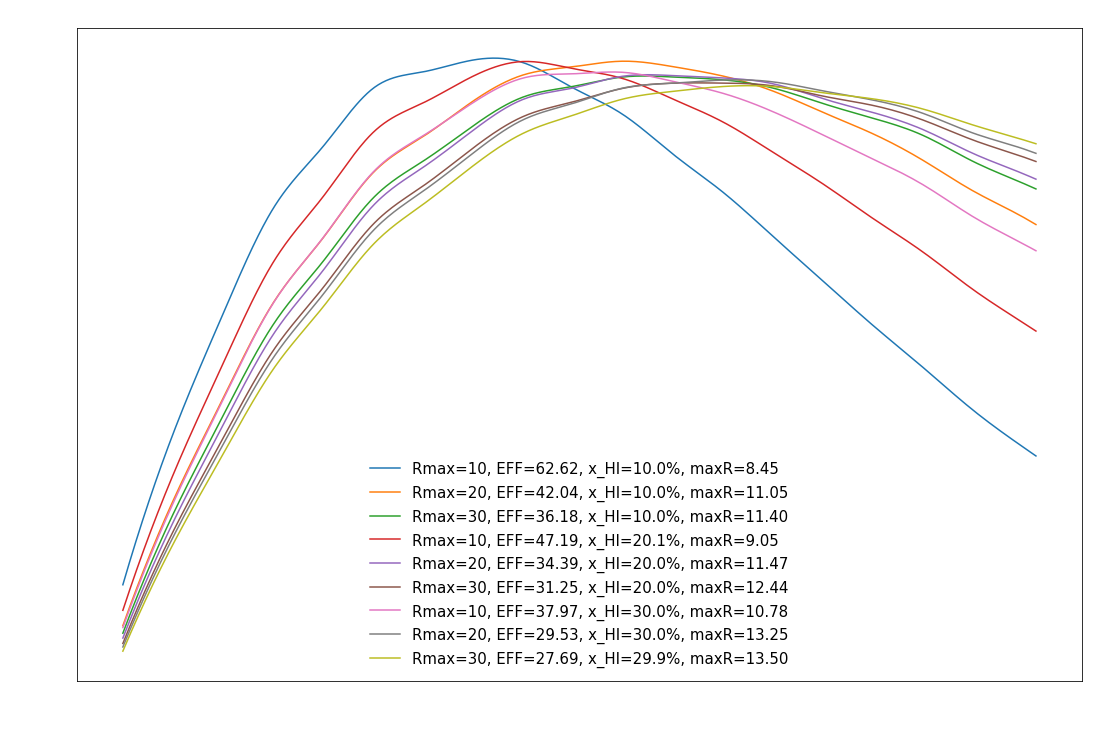

In [75]:
color='white'
percent=0.475

mfp_maxRs = np.zeros(len(mfp_size_probabilities))

plt.rcParams['figure.figsize'] = [18, 12]
for i, mfp_size_probability in enumerate(mfp_size_probabilities):
    
    mfp_maxRs[i] = mfp_neutral_region_size[np.argmax(mfp_size_probability)]
    
    plt.plot(
        mfp_neutral_region_size[:int(percent*bin_num_mfp)], 
        mfp_size_probability[:int(percent*bin_num_mfp)], 
        '-',
        label=f'Rmax={R_BUBBLE_MAXES[i]:d}, EFF={HII_EFF_FACTORS[i]:.2f}, \
x_HI={total_neutral_fractions[i]*100:.1f}%, \
maxR={mfp_maxRs[i]:.2f}'
    )
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$R$ (Mpc)', color=color)
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$', color=color)
plt.title(f'Our Boxes, MFP method: Vary: Rmax, EFF, constant: x_HI, z={redshifts[0]} ({iteration_mfp:.0e} iterations)', color=color)
plt.rcParams['font.size'] = 18
# plt.yscale('log')

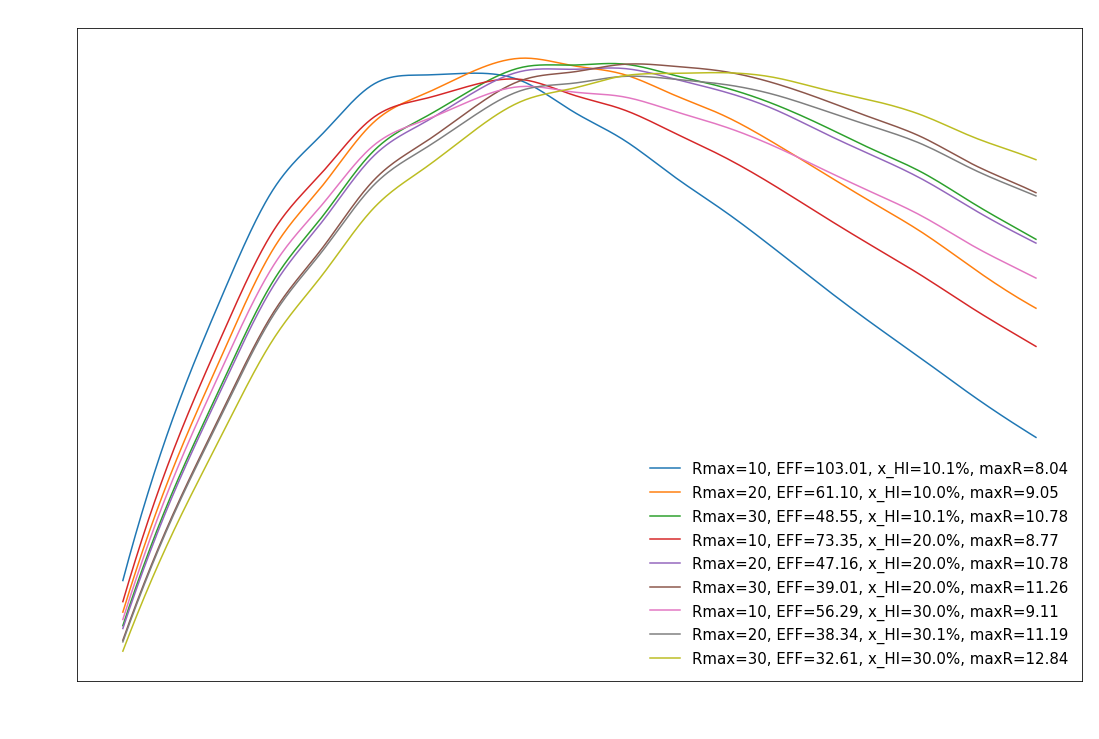

In [99]:
color='white'
percent=0.475

Freds_mfp_maxRs = np.zeros(len(Freds_mfp_size_probabilities))

plt.rcParams['figure.figsize'] = [18, 12]
for i, prob in enumerate(Freds_mfp_size_probabilities):
    
    Freds_mfp_maxRs[i] = Freds_mfp_neutral_region_size[np.argmax(prob)]
    
    plt.plot(
        Freds_mfp_neutral_region_size[:int(percent*bin_num_mfp)], 
        prob[:int(percent*bin_num_mfp)], 
        '-',
        label=f'Rmax={R_BUBBLE_MAXES[i]:d}, EFF={Freds_HII_EFF_FACTORS[i]:.2f}, \
x_HI={Freds_total_neutral_fractions[i]*100:.1f}%, \
maxR={Freds_mfp_maxRs[i]:.2f}'
    )
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
plt.tick_params(color=color, labelcolor=color)
plt.xlabel('$R$ (Mpc)', color=color)
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$', color=color)
plt.title(f"Fred's Boxes, MFP method: Vary: Rmax, EFF, constant: x_HI, z={redshifts[0]} ({iteration_mfp:.0e} iterations)", color=color)
plt.rcParams['font.size'] = 18
# plt.yscale('log')

## Making fof 3x3 plots

In [67]:
def fof_plot(
    x1s,
    y1s, 
    figure_shape, 
    title=None, 
    shared_title=None,
    shared_title_x_position=0.5,   # figure coordinates, max=1 I think
    shared_title_y_position=0.93,
    shared_x_label=None, 
    shared_x_label_x_position=0.5,
    shared_x_label_y_position=0.08,
    shared_y_label=None, 
    shared_y_label_x_position=0.07,
    shared_y_label_y_postion=0.5,
    color='white', 
    figure_size=(18,19), 
    font_size=15, 
    horizontal_gap=0.05, 
    vertical_gap=0.05, 
    y_scale='log', 
    x_scale='log', 
    y_notation='plain', 
    share_x_axis=True, 
    share_y_axis=True,
    dpi=100
):
                    
    fig, axes = plt.subplots(
        figure_shape[0], 
        figure_shape[1], 
        figsize=figure_size, 
        sharex=share_x_axis, 
        sharey=share_y_axis, 
        gridspec_kw={"hspace":vertical_gap, 'wspace':horizontal_gap},
        dpi=dpi
    )

    if shared_title != None:

        fig.suptitle(
            x=shared_title_x_position, 
            y=shared_title_y_position, 
            t=shared_title, ha='center', 
            size=1.5*font_size, 
            color=color
        )

    if shared_x_label != None:  # shared x label
        fig.text(
            x=shared_x_label_x_position, 
            y=shared_x_label_y_position, 
            s=shared_x_label, ha='center', 
            size=font_size, 
            color=color
        )

    if shared_y_label != None:  # shared y label
        fig.text(
            x=shared_y_label_x_position, 
            y=shared_y_label_y_postion, 
            s=shared_y_label, 
            va='center', 
            rotation='vertical', 
            size=font_size, 
            color=color
        )

    for i, y1 in enumerate(y1s):

        axes.flatten()[i].step(
        x1s[i][:int((bin_num_fof+1)*percent)], 
        y1[:int((bin_num_fof+1)*percent)]
        )

        if title != None:
            axes.flatten()[i].set_title(title[i], color=color, fontsize=font_size)

        axes.flatten()[i].set_yscale(y_scale)
        axes.flatten()[i].set_xscale(x_scale)

        if y_notation == 'sci':
            axes.flatten()[i].ticklabel_format(
                axis='y', 
                style=y_notation, 
                scilimits=(0,0), 
                useMathText=True
            )

        axes.flatten()[i].tick_params(
            color=color, 
            labelcolor=color, 
            labelsize=font_size, 
            size=font_size
        )  # font style

        for spine in axes.flatten()[i].spines.values():  # figure color
            spine.set_edgecolor(color)

    plt.show()

## Calling function to generate neutral region size distributions with fof()

In [86]:
bin_num_fof = int(2e2)
fof_sizes = np.zeros((len(redshifts), bin_num_fof+1))
fof_sizes_probabilities = np.zeros((len(redshifts), bin_num_fof+1))
for i, box in enumerate(ionized_boxes):
    fof_sizes[i], fof_sizes_probabilities[i], _ = plot_fof_sizes(
        fof(box)[1], 
        bins=bin_num_fof, 
        boxsize=BOX_LEN
    )

Program runtime: 0.015715 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.015209 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.014800 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.016761 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.016736 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.016212 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowes

In [88]:
bin_num_fof = int(2e2)
Freds_fof_sizes = np.zeros((len(redshifts), bin_num_fof+1))
Freds_fof_sizes_probabilities = np.zeros((len(redshifts), bin_num_fof+1))
for i, box in enumerate(Freds_boxes):
    Freds_fof_sizes[i], Freds_fof_sizes_probabilities[i], _ = plot_fof_sizes(
        fof(box)[1], 
        bins=bin_num_fof, 
        boxsize=BOX_LEN
    )

Program runtime: 0.033308 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.032687 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.031855 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.037823 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.033506 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value
Program runtime: 0.052448 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowes

## Plotting fof() distributions

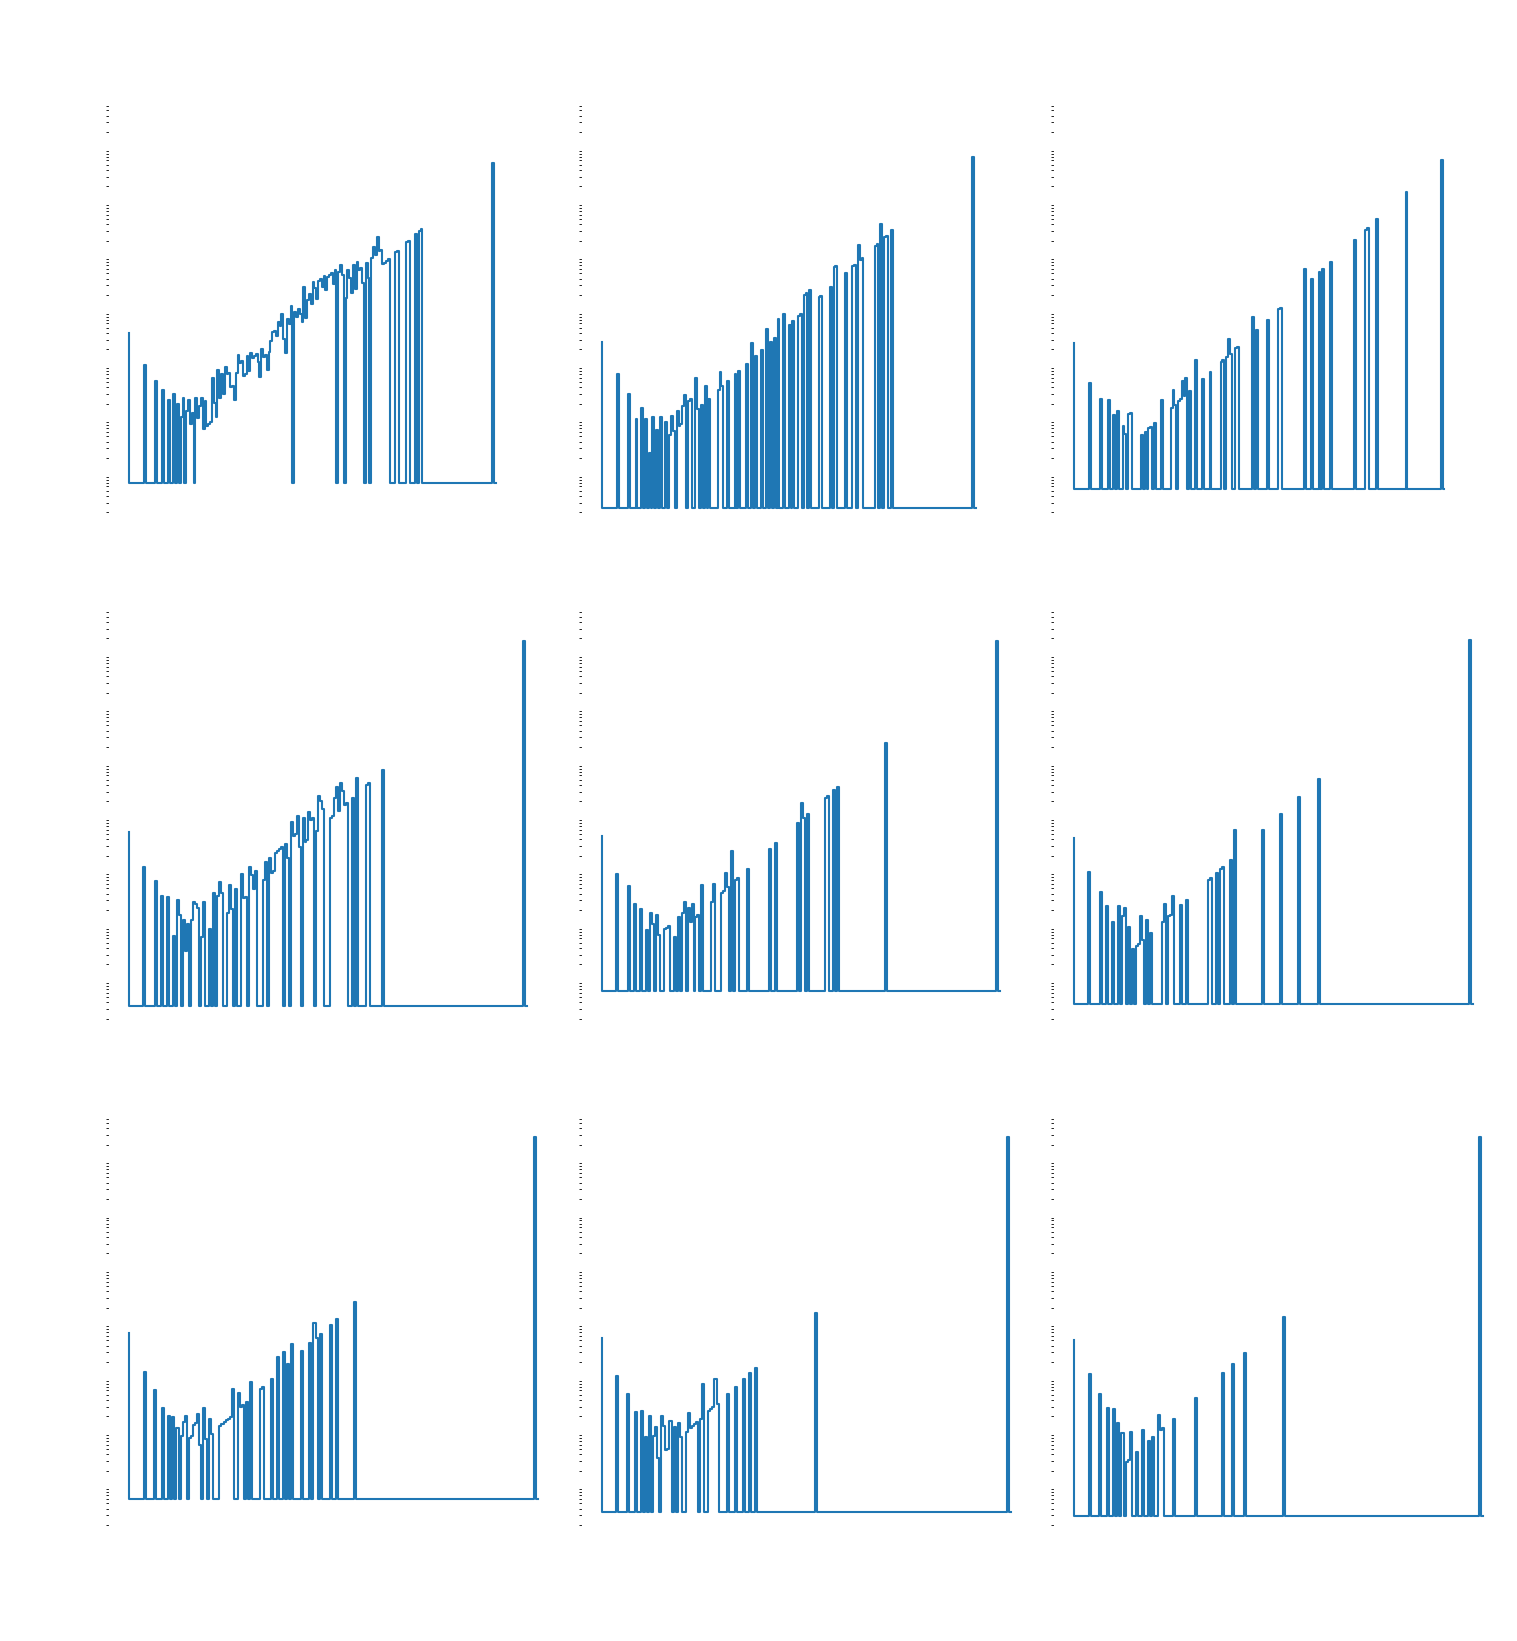

In [90]:
percent=1
which_max = [
    '2ndMax',  # 1
    '2ndMax',  # 2
    '3rdMax',  # 3
    '2ndMax',  # 4
    '3rdMax',  # 5
    '2ndMax',  # 6
    '2ndMax',  # 7
    '4thMax',  # 8
    '4thMax']  # 9
which_max_ind = np.array(
    [2,  # 1
     2,  # 2
     3,  # 3
     2,  # 4
     3,  # 5
     2,  # 6
     2,  # 7
     4,  # 8
     4]) # 9

fof_plot(
    x1s=fof_sizes,
    y1s=fof_sizes_probabilities,
    figure_shape=[3,3],
    title=[f'Rmax={R_BUBBLE_MAXES[i]:d}, EFF={HII_EFF_FACTORS[i]:.2f}, \
\nx_HI={total_neutral_fractions[i]*100:.1f}%, \
{which_max[i]}={fof_sizes[i][np.argsort(probability)[-which_max_ind[i]]]:.1e}\
' for i, probability in enumerate(fof_sizes_probabilities)],
    vertical_gap=0.2,
    shared_x_label='$V$ (Mpc$^3$)',
    shared_y_label='$V^2\mathrm{d}P/\mathrm{d}V$',
    shared_title=f'Our boxes, FOF method: Vary: Rmax, EFF, constant: x_HI, z={redshifts[0]}'
)

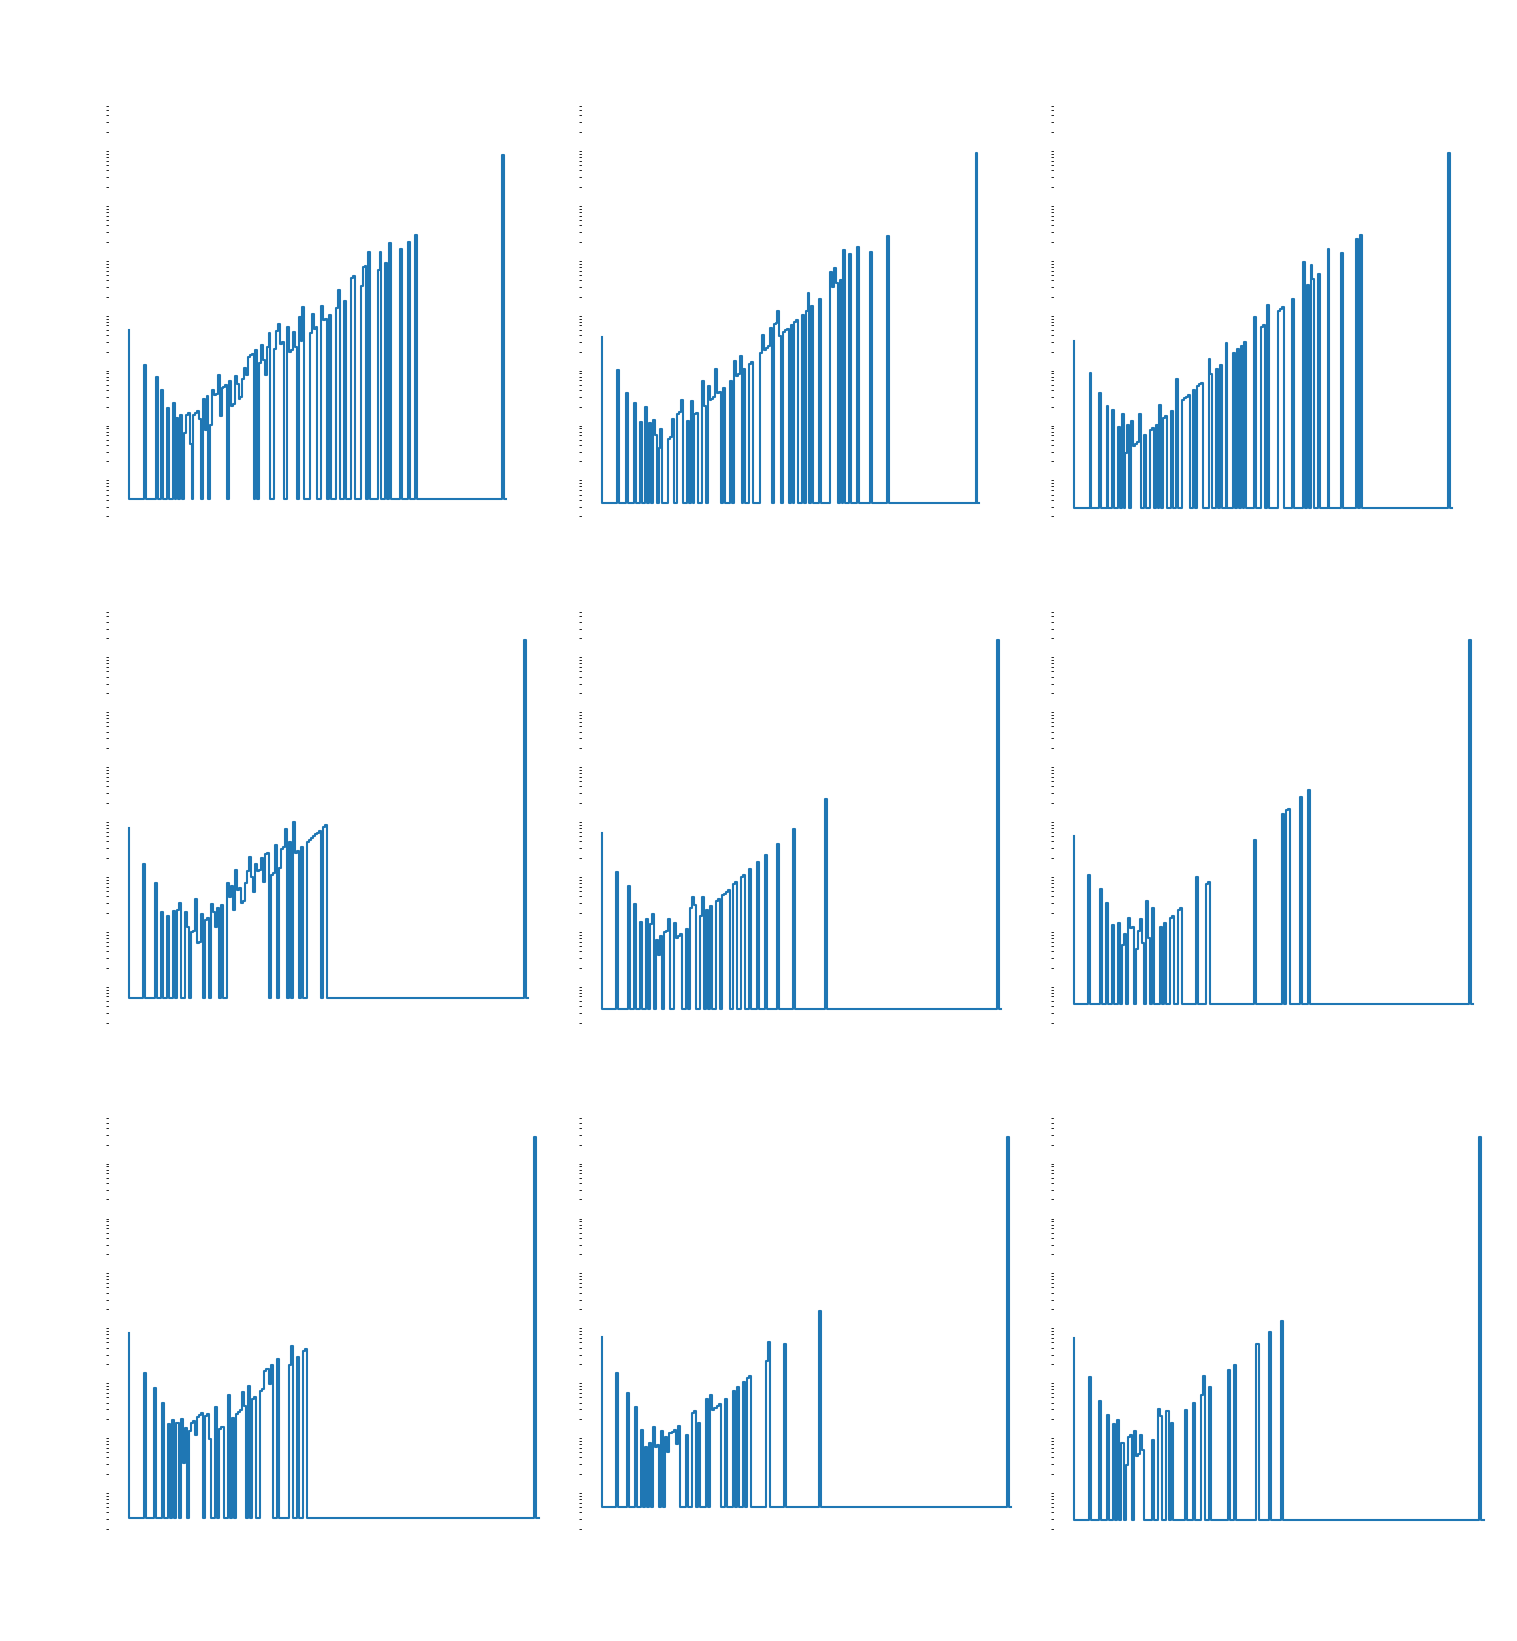

In [94]:
percent=1
which_max = [
    '2ndMax',  # 1
    '2ndMax',  # 2
    '2ndMax',  # 3
    '2ndMax',  # 4
    '3rdMax',  # 5
    '2ndMax',  # 6
    '4thMax',  # 7
    '5thMax',  # 8
    '2ndMax']  # 9
which_max_ind = np.array(
    [2,  # 1
     2,  # 2
     2,  # 3
     2,  # 4
     3,  # 5
     2,  # 6
     4,  # 7
     5,  # 8
     2]) # 9

fof_plot(
    x1s=Freds_fof_sizes,
    y1s=Freds_fof_sizes_probabilities,
    figure_shape=[3,3],
    title=[f'Rmax={R_BUBBLE_MAXES[i]:d}, EFF={Freds_HII_EFF_FACTORS[i]:.2f}, \
\nx_HI={Freds_total_neutral_fractions[i]*100:.1f}%, \
{which_max[i]}={Freds_fof_sizes[i][np.argsort(probability)[-which_max_ind[i]]]:.1e}\
' for i, probability in enumerate(Freds_fof_sizes_probabilities)],
    vertical_gap=0.2,
    shared_x_label='$V$ (Mpc$^3$)',
    shared_y_label='$V^2\mathrm{d}P/\mathrm{d}V$',
    shared_title=f"Fred's boxes, FOF method: Vary: Rmax, EFF, constant: x_HI, z={redshifts[0]}"
)

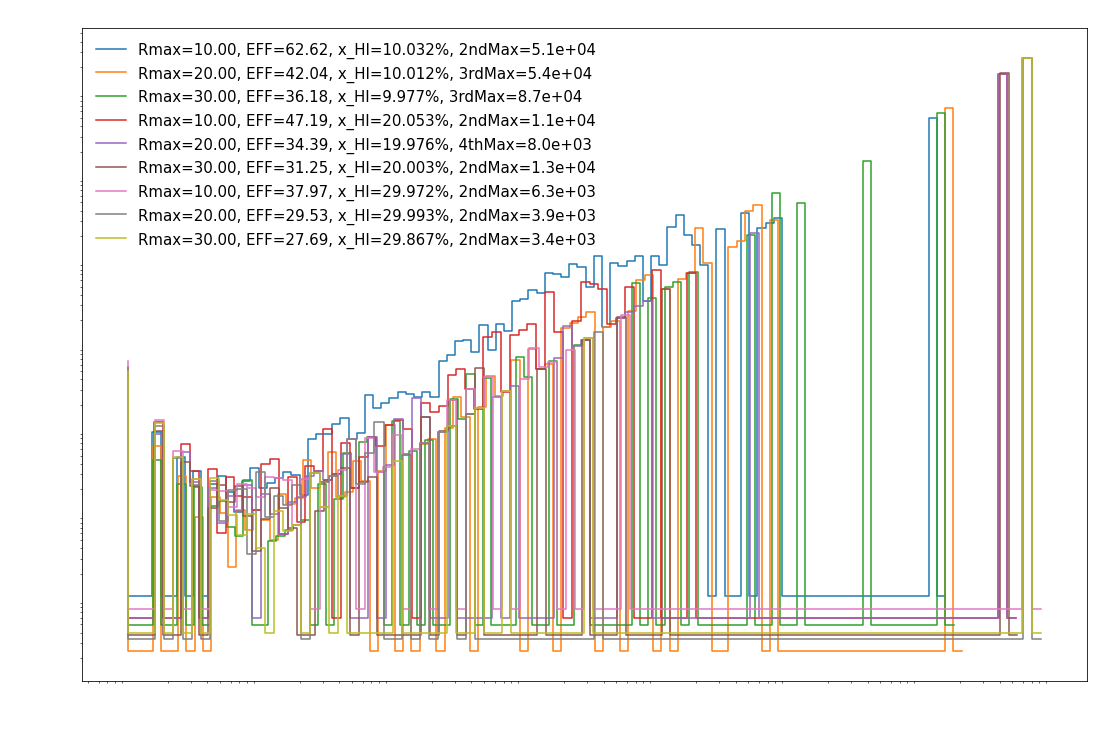

In [70]:
color='white'
percent=1
which_max = [
    '2ndMax', 
    '3rdMax', 
    '3rdMax', 
    '2ndMax', 
    '4thMax', 
    '2ndMax', 
    '2ndMax', 
    '2ndMax', 
    '2ndMax'
]
which_max_ind = np.array([2, 3, 3, 2, 4, 2, 2, 2, 2])

plt.rcParams['figure.figsize'] = [18, 12]

for i, probability in enumerate(fof_sizes_probabilities):
    plt.step(
        fof_sizes[i][:int((bin_num_fof+1)*percent)], 
        probability[:int((bin_num_fof+1)*percent)], 
        label=f'Rmax={R_BUBBLE_MAXES[i]:.2f}, EFF={HII_EFF_FACTORS[i]:.2f}, \
x_HI={total_neutral_fractions[i]*100:.3f}%, \
{which_max[i]}={fof_sizes[i][np.argsort(probability)[-which_max_ind[i]]]:.1e}'
    )

plt.xscale('log')
plt.yscale('log')
plt.legend(prop={'size': 15}, fancybox=True, framealpha=0)
# plt.ylim(fof_dist[2],1)


plt.xlabel('$V$ (Mpc$^3$)', color=color)
plt.ylabel('$V^2\mathrm{d}P/\mathrm{d}V$', color=color)
plt.title(f'FOF method: Vary: Rmax, EFF, constant: x_HI, z={redshifts[0]}', color=color)
plt.tick_params(color=color, labelcolor=color)
plt.rcParams['font.size'] = 18

plt.show()